# Clasificaci√≥n No Balanceada en Inversiones Startups (Crunchbase)

Este trabajo aborda un problema de **clasificaci√≥n binaria no balanceada** a partir de un dataset abierto de inversiones en startups, disponible en [Kaggle - Startup Investments Crunchbase](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

## Descripci√≥n del Proyecto

Este proyecto se desarrolla para la asignatura de **Miner√≠a de Datos**, como parte del trabajo final grupal. El objetivo es aplicar t√©cnicas de an√°lisis y modelado sobre un conjunto de datos reales para abordar un problema de clasificaci√≥n desequilibrada.

A partir del dataset original, se ha redefinido el problema como una clasificaci√≥n binaria no balanceada. Por ejemplo, se puede predecir si una startup ha recibido financiaci√≥n por encima de un determinado umbral, o si pertenece a un grupo de industrias consideradas ‚Äúde alto crecimiento‚Äù.

## Objetivos

1. **Formulaci√≥n del problema** como tarea de clasificaci√≥n binaria no balanceada.
2. **An√°lisis exploratorio** de las variables del dataset.
3. **Preparaci√≥n de los datos**, incluyendo tratamiento de valores perdidos, normalizaci√≥n, codificaci√≥n y detecci√≥n de outliers.
4. Aplicaci√≥n de **t√©cnicas de aprendizaje supervisado**:
   - **K-Nearest Neighbors (KNN)**
   - **√Årboles de Decisi√≥n**
5. Evaluaci√≥n mediante **m√©tricas adecuadas** para clasificaci√≥n no balanceada (como *F1-Score*, *balanced accuracy*, *AUC*, etc.) y **validaci√≥n cruzada**.
6. Uso de **pipelines y transformadores** para automatizar el preprocesamiento.
7. Aplicaci√≥n de t√©cnicas de **muestreo (undersampling/oversampling)** y **ajuste de umbrales**.
8. Estudio de la **interpretabilidad del modelo final**.

## Estructura del Notebook

Este notebook est√° estructurado en las siguientes secciones:

- [1. Carga y descripci√≥n del dataset](#)
- [2. An√°lisis exploratorio de los datos (EDA)](#)
- [3. Formulaci√≥n del problema de clasificaci√≥n binaria no balanceada](#)
- [4. Preprocesamiento de datos](#)
- [5. Construcci√≥n del pipeline con KNN](#)
- [6. Evaluaci√≥n del modelo y an√°lisis de resultados](#)
- [7. √Årboles de decisi√≥n y comparaci√≥n](#)
- [8. Interpretabilidad del modelo final](#)
- [9. Conclusiones](#)

## 1. Elecci√≥n del problema

El problema elegido se basa en el dataset **Startup Investments - Crunchbase**, disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo es construir un modelo de **clasificaci√≥n binaria no balanceada** que permita **predecir si una startup ser√° adquirida** o no. Para ello, hemos definido la variable objetivo `target` de la siguiente forma:

- `target = 1` si la columna `status` es `"acquired"`
- `target = 0` en cualquier otro caso (por ejemplo: `closed`, `ipo`, `operating`, etc.)

Este planteamiento genera un claro desbalance entre clases, ya que el n√∫mero de startups adquiridas es mucho menor que el resto.

Comenzamos leyendo el dataset original sobre inversiones en startups, proporcionado por Crunchbase y disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo en esta fase inicial es familiarizarnos con la estructura de los datos: n√∫mero de ejemplos, variables disponibles, tipos de datos y primeras observaciones. Esto nos permitir√° definir correctamente el problema de clasificaci√≥n binaria no balanceada.

El archivo utilizado se llama `investments_VC.csv` y se encuentra en la carpeta `data/`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_recall_curve, auc

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

In [2]:
ruta_datos = "data/investments_VC.csv"

df = pd.read_csv(ruta_datos, encoding="latin1")

print("Dimensiones del dataset: ", df.shape)
pd.set_option('display.max_columns', None)
df.head()

Dimensiones del dataset:  (54294, 39)


permalink                name  \
0            /organization/waywire            #waywire   
1  /organization/tv-communications  &TV Communications   
2    /organization/rock-your-paper   'Rock' Your Paper   
3   /organization/in-touch-network   (In)Touch Network   
4   /organization/r-ranch-and-mine  -R- Ranch and Mine   

                    homepage_url  \
0         http://www.waywire.com   
1          http://enjoyandtv.com   
2   http://www.rockyourpaper.org   
3  http://www.InTouchNetwork.com   
4                            NaN   

                                       category_list        market   \
0         |Entertainment|Politics|Social Media|News|          News    
1                                            |Games|         Games    
2                             |Publishing|Education|    Publishing    
3  |Electronics|Guides|Coffee|Restaurants|Music|i...   Electronics    
4                      |Tourism|Entertainment|Games|       Tourism    

   funding_total_usd      status country_code state_code         region  \
0          17,50,000    acquired          USA         NY  New York City   
1          40,00,000   operating          USA         CA    Los Angeles   
2             40,000   operating          EST        NaN        Tallinn   
3          15,00,000   operating          GBR        NaN         London   
4             60,000   operating          USA         TX         Dallas   

          city  funding_rounds  founded_at founded_month founded_quarter  \
0     New York             1.0  2012-06-01       2012-06         2012-Q2   
1  Los Angeles             2.0         NaN           NaN             NaN   
2      Tallinn             1.0  2012-10-26       2012-10         2012-Q4   
3       London             1.0  2011-04-01       2011-04         2011-Q2   
4   Fort Worth             2.0  2014-01-01       2014-01         2014-Q1   

   founded_year first_funding_at last_funding_at       seed    venture  \
0        2012.0       2012-06-30      2012-06-30  1750000.0        0.0   
1           NaN       2010-06-04      2010-09-23        0.0  4000000.0   
2        2012.0       2012-08-09      2012-08-09    40000.0        0.0   
3        2011.0       2011-04-01      2011-04-01  1500000.0        0.0   
4        2014.0       2014-08-17      2014-09-26        0.0        0.0   

   equity_crowdfunding  undisclosed  convertible_note  debt_financing  angel  \
0                  0.0          0.0               0.0             0.0    0.0   
1                  0.0          0.0               0.0             0.0    0.0   
2                  0.0          0.0               0.0             0.0    0.0   
3                  0.0          0.0               0.0             0.0    0.0   
4              60000.0          0.0               0.0             0.0    0.0   

   grant  private_equity  post_ipo_equity  post_ipo_debt  secondary_market  \
0    0.0             0.0              0.0            0.0               0.0   
1    0.0             0.0              0.0            0.0               0.0   
2    0.0             0.0              0.0            0.0               0.0   
3    0.0             0.0              0.0            0.0               0.0   
4    0.0             0.0              0.0            0.0               0.0   

   product_crowdfunding  round_A  round_B  round_C  round_D  round_E  round_F  \
0                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   round_G  round_H  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0

## 0. Limpieza de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

Para reducir datos redundantes e innecesarios, eliminamos columnas que no nos hacen falta para nuestro modelo:
- `permalink`: Es una URL √∫nica que identifica a la empresa dentro de la base de datos original.
- `name`: aunque representa el nombre de la empresa, no es necesario para los objetivos de clasificaci√≥n ni para el an√°lisis cuantitativo, por lo que tambi√©n se ha descartado.
- `debt-financing`: la eliminamos porque consideramos que distorsiona el resultado, dado que estar en deuda no es necesariamente un buen predictor del √©xito, en su lugar, nos centramos en `venture`, que se es considerafo el equivalente a la inversi√≥n.
- `post_ipo_equity`: financiaci√≥n despu√©s de una salida a bolsa (IPO). No es relevante para nuestro an√°lisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.
- `post_ipo_debt`: deuda despu√©s de haber salido a bolsa. No es relevante para nuestro an√°lisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.


In [4]:
df = df.drop(columns=['permalink', 'name', "post_ipo_equity", "post_ipo_debt", "debt_financing"], axis=1)

As√≠ mismo, podemos eliminar duplicados si es que hay alguno

In [5]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(54294, 34)
(49377, 34)


Podemos observar que hay variables con formato incorrecto en el nombre y otras con espacios como `market` y `funding_total_usd`, por lo que lo arreglamos:

In [6]:
# Nos aseguramos de que no haya espacios en los nombres de las variables
df.columns = df.columns.str.strip()
# Convertimos la variable funding_total_usd a un float y cambiamos los - por NaN
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'].str.replace(',', ''), errors='coerce')

Tambi√©n contamos con muchas variables que son fechas, por lo que para asegurar la consistencia de los datos las transformamos al tipo de dato correcto

In [7]:
#turning all date columns in to date
df['founded_at'] =  pd.to_datetime(df['founded_at'], format='%Y-%m-%d', errors = 'coerce') # conveting column into date and ignoring errors
df['first_funding_at'] =  pd.to_datetime(df['first_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['last_funding_at'] =  pd.to_datetime(df['last_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['founded_year'] =  pd.to_datetime(df['founded_year'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors
df['founded_month'] =  pd.to_datetime(df['founded_month'], format='%Y-%m', errors = 'coerce') # conveting column into date and ignoring errors

Adem√°s, dado que `status` es nuestra variable objetivo, ser√≠a mejor eliminar las filas donde no tengamos dicho campo.

In [8]:
print(df.shape)
df = df.dropna(subset = ['status'])
print(df.shape)

(49377, 34)
(48062, 34)


## 2. M√©trica de rendimiento y validaci√≥n

Dado que se trata de un problema de **clasificaci√≥n no balanceada**, y el enfoque del proyecto es el de una entidad inversora interesada en identificar startups que realmente ser√°n adquiridas, el objetivo por tanto, ser√° optimizar el n√∫mero de **falsos positivos**, es decir, evitar etiquetar como "adquirida" una startup que realmente no lo ser√°, lo cual es crucial desde una perspectiva de inversi√≥n.

Para ello, utilizaremos como m√©tricas principales **FŒ≤-score** y **AUC - Precision Recall**. Como nos interesa minimizar el n√∫mero de falsos positivos, tenemos que dar m√°s peso a la precisi√≥n. Por ello, al valor de beta le asignamos un valor <1, le daremos un valor 0.7.

- **FŒ≤-score**: como nos explic√≥ en clase de pr√°cticas, permite ajustar la importancia del *recall* frente a la *precisi√≥n*, seg√∫n lo que queramos priorizar.
- **AUC - Precision Recall**: eval√∫a qu√© tan bien se separan las clases, especialmente en problemas desbalanceados.



### Validaci√≥n

Usaremos Hold-out estratificado porque as√≠ nos aseguramos de que cada partici√≥n de nuestro conjunto de datos mantenga la misma proporci√≥n de clases que el conjunto original. Esto es muy importante en nuestro caso, ya que tenemos un problema de clasificaci√≥n en el que las clases est√°n desbalanceadas. Al asegurarnos de que cada fold represente la distribuci√≥n de clases, evitamos sesgos en la evaluaci√≥n del rendimiento y obtenemos mejores estimaciones. Adem√°s, nos ayuda a usar mejor nuestros datos y a entrenar modelos que aprendan de forma m√°s equilibrada y realista seg√∫n c√≥mo es de verdad el problema.


In [9]:
from collections import Counter

# def evaluar_pipeline(X, y, pipeline, beta=0.7, test_size=0.2, max_intentos=10, random_state=1):
#     """Eval√∫a un pipeline usando hold-out estratificado, garantizando que haya al menos 2 clases en y_train."""

#     for intento in range(max_intentos):
#         X_train, X_test, y_train, y_test = train_test_split(
#             X, y, test_size=test_size, stratify=y, random_state=random_state + intento
#         )

#         if len(np.unique(y_train)) > 1:
#             break  # tenemos ambas clases ‚Üí podemos seguir
#     else:
#         raise ValueError("No se pudo obtener un conjunto de entrenamiento con m√°s de una clase.")

#     # Entrenar y evaluar
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)

#     # Probabilidades (si existen)
#     if hasattr(pipeline, "predict_proba"):
#         y_proba = pipeline.predict_proba(X_test)[:, 1]
#     elif hasattr(pipeline, "decision_function"):
#         y_proba = pipeline.decision_function(X_test)
#     else:
#         y_proba = None

#     puntuaciones = {
#         "f_beta": fbeta_score(y_test, y_pred, beta=beta),
#     }

#     if y_proba is not None:
#         precision, recall, _ = precision_recall_curve(y_test, y_proba)
#         puntuaciones["AUC-PR"] = auc(recall, precision)
#     else:
#         puntuaciones["AUC-PR"] = 0.0

#     return puntuaciones
def evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline, beta=0.7):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    f = fbeta_score(y_val, y_pred, beta=beta)
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    auc_score = auc(recall, precision)

    print("==== Evaluaci√≥n del modelo ====")
    print(f"F{beta}-score: {f:.4f}")
    print(f"AUC-PR:      {auc_score:.4f}")

    return {'f_beta': f, 'AUC-PR': auc_score}


## 3. An√°lisis de las variables de entrada

El dataset contiene informaci√≥n sobre startups, incluyendo el pa√≠s, la categor√≠a, la cantidad de inversi√≥n recibida, el n√∫mero de rondas de financiaci√≥n, y fechas clave como fundaci√≥n y adquisiciones.

Variables candidatas para el modelo:

- `country_code`
- `category_code`
- `funding_total_usd`
- `funding_rounds`
- `founded_at`
- `first_funding_at`
- `last_funding_at`

Se han detectado:
- Variables num√©ricas con escalas muy diferentes
- Fechas con valores ausentes o mal formateados
- Variables categ√≥ricas con muchos valores √∫nicos
- Campos de texto que se ignorar√°n o transformar√°n

El an√°lisis preliminar sugiere que las startups con m√°s financiaci√≥n y m√°s rondas de inversi√≥n tienen mayor probabilidad de ser adquiridas.


Lo primero que hacemos es renombrar la variable a predecir. Se llama `status` y le llamamos `exito`.

In [10]:
df.rename(columns = {'status':'exito'}, inplace = True)
pd.set_option('display.max_columns', None)
df.head()
#borrar variables: 
# permalink, name, state_code


homepage_url  \
0         http://www.waywire.com   
1          http://enjoyandtv.com   
2   http://www.rockyourpaper.org   
3  http://www.InTouchNetwork.com   
4                            NaN   

                                       category_list         market  \
0         |Entertainment|Politics|Social Media|News|          News    
1                                            |Games|         Games    
2                             |Publishing|Education|    Publishing    
3  |Electronics|Guides|Coffee|Restaurants|Music|i...   Electronics    
4                      |Tourism|Entertainment|Games|       Tourism    

   funding_total_usd      exito country_code state_code         region  \
0          1750000.0   acquired          USA         NY  New York City   
1          4000000.0  operating          USA         CA    Los Angeles   
2            40000.0  operating          EST        NaN        Tallinn   
3          1500000.0  operating          GBR        NaN         London   
4            60000.0  operating          USA         TX         Dallas   

          city  funding_rounds founded_at founded_month founded_quarter  \
0     New York             1.0 2012-06-01    2012-06-01         2012-Q2   
1  Los Angeles             2.0        NaT           NaT             NaN   
2      Tallinn             1.0 2012-10-26    2012-10-01         2012-Q4   
3       London             1.0 2011-04-01    2011-04-01         2011-Q2   
4   Fort Worth             2.0 2014-01-01    2014-01-01         2014-Q1   

  founded_year first_funding_at last_funding_at       seed    venture  \
0   2012-01-01       2012-06-30      2012-06-30  1750000.0        0.0   
1          NaT       2010-06-04      2010-09-23        0.0  4000000.0   
2   2012-01-01       2012-08-09      2012-08-09    40000.0        0.0   
3   2011-01-01       2011-04-01      2011-04-01  1500000.0        0.0   
4   2014-01-01       2014-08-17      2014-09-26        0.0        0.0   

   equity_crowdfunding  undisclosed  convertible_note  angel  grant  \
0                  0.0          0.0               0.0    0.0    0.0   
1                  0.0          0.0               0.0    0.0    0.0   
2                  0.0          0.0               0.0    0.0    0.0   
3                  0.0          0.0               0.0    0.0    0.0   
4              60000.0          0.0               0.0    0.0    0.0   

   private_equity  secondary_market  product_crowdfunding  round_A  round_B  \
0             0.0               0.0                   0.0      0.0      0.0   
1             0.0               0.0                   0.0      0.0      0.0   
2             0.0               0.0                   0.0      0.0      0.0   
3             0.0               0.0                   0.0      0.0      0.0   
4             0.0               0.0                   0.0      0.0      0.0   

   round_C  round_D  round_E  round_F  round_G  round_H  
0      0.0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0      0.0

Ahora visualizamos la descripci√≥n de nuestro dataset con `describe` de la libr√≠a `pandas`

In [11]:
df.describe()

funding_total_usd  funding_rounds                     founded_at  \
count       3.975200e+04    48062.000000                          37633   
mean        1.601676e+07        1.701490  2007-05-03 08:17:21.553955328   
min         1.000000e+00        1.000000            1785-01-01 00:00:00   
25%         3.533405e+05        1.000000            2005-12-01 00:00:00   
50%         2.000000e+06        1.000000            2010-01-01 00:00:00   
75%         1.000000e+07        2.000000            2012-01-01 00:00:00   
max         3.007950e+10       18.000000            2014-12-13 00:00:00   
std         1.709537e+08        1.298889                            NaN   

                       founded_month                   founded_year  \
count                          37562                          37562   
mean   2007-08-04 04:13:31.202811392  2007-05-23 01:11:55.169586176   
min              1902-01-01 00:00:00            1902-01-01 00:00:00   
25%              2006-01-01 00:00:00            2006-01-01 00:00:00   
50%              2010-01-01 00:00:00            2010-01-01 00:00:00   
75%              2012-01-01 00:00:00            2012-01-01 00:00:00   
max              2014-12-01 00:00:00            2014-01-01 00:00:00   
std                              NaN                            NaN   

                 first_funding_at                last_funding_at  \
count                       48052                          48056   
mean   2011-03-10 22:21:04.629984  2012-01-20 04:03:36.946895360   
min           1921-09-01 00:00:00            1921-09-01 00:00:00   
25%           2009-08-07 00:00:00            2010-10-01 00:00:00   
50%           2011-12-01 00:00:00            2012-12-01 00:00:00   
75%           2013-08-01 00:00:00            2014-02-01 00:00:00   
max           2014-12-31 00:00:00            2015-01-01 00:00:00   
std                           NaN                            NaN   

               seed       venture  equity_crowdfunding   undisclosed  \
count  4.806200e+04  4.806200e+04         4.806200e+04  4.806200e+04   
mean   2.193655e+05  7.607892e+06         6.263949e+03  1.275071e+05   
min    0.000000e+00  0.000000e+00         0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00         0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00         0.000000e+00  0.000000e+00   
75%    2.500000e+04  5.000000e+06         0.000000e+00  0.000000e+00   
max    1.300000e+08  2.351000e+09         2.500000e+07  2.924328e+08   
std    1.069244e+06  2.879473e+07         2.025639e+05  2.973136e+06   

       convertible_note         angel         grant  private_equity  \
count      4.806200e+04  4.806200e+04  4.806200e+04    4.806200e+04   
mean       2.356382e+04  6.614196e+04  1.628444e+05    2.086034e+06   
min        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
25%        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
50%        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
75%        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
max        3.000000e+08  6.359026e+07  7.505000e+08    3.500000e+09   
std        1.451765e+06  6.649830e+05  5.668161e+06    3.201378e+07   

       secondary_market  product_crowdfunding       round_A       round_B  \
count      4.806200e+04          4.806200e+04  4.806200e+04  4.806200e+04   
mean       3.945911e+04          7.173288e+03  1.259606e+06  1.514252e+06   
min        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
50%        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
75%        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
max        6.806116e+08          7.200000e+07  3.190000e+08  5.420000e+08   
std        3.919327e+06          4.339788e+05  5.580942e+06  7.549580e+06   

            round_C       round_D       round_E       round_F       round_G  \
count  4.806200e

Para comenzar nuestro an√°lisis, podemos mirar una posible existencia de valores perdidos en nuestras variables para identificar patrones.

                                   Columna  Valores nulos  \
state_code                      state_code          18532   
founded_year                  founded_year          10500   
founded_quarter            founded_quarter          10500   
founded_month                founded_month          10500   
founded_at                      founded_at          10429   
funding_total_usd        funding_total_usd           8310   
city                                  city           5821   
country_code                  country_code           5032   
region                              region           5032   
market                              market           3528   
category_list                category_list           3521   
homepage_url                  homepage_url           3316   
first_funding_at          first_funding_at             10   
last_funding_at            last_funding_at              6   
funding_rounds              funding_rounds              0   
exito                   

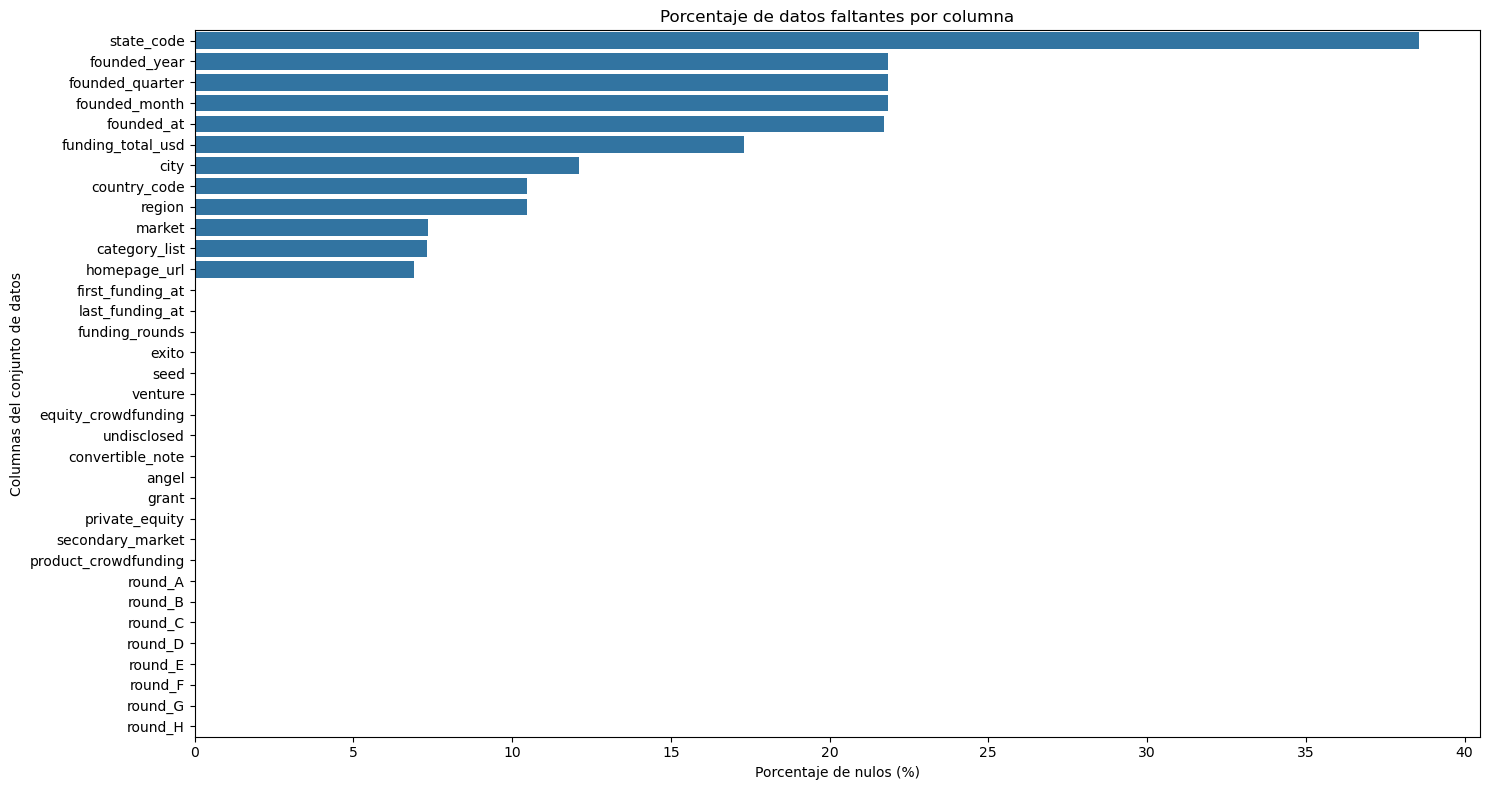

In [12]:
# 1. Calcular el n√∫mero de valores nulos por columna
valores_nulos = df.isnull().sum()

# 2. Calcular el porcentaje de valores nulos por columna
porcentaje_nulos = (valores_nulos / len(df)) * 100

# 3. Crear un DataFrame resumen con los datos faltantes
datos_faltantes = pd.DataFrame({
    'Columna': df.columns,
    'Valores nulos': valores_nulos,
    'Porcentaje de nulos (%)': porcentaje_nulos
}).sort_values(by='Porcentaje de nulos (%)', ascending=False)

# 4. Mostrar la tabla
print(datos_faltantes)

# 5. Visualizaci√≥n con Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x='Porcentaje de nulos (%)', y='Columna', data=datos_faltantes)
plt.title('Porcentaje de datos faltantes por columna')
plt.xlabel('Porcentaje de nulos (%)')
plt.ylabel('Columnas del conjunto de datos')
plt.tight_layout()
plt.show()

Se puede ver que la variable con mayor n√∫mero de datos faltantes est√° en `state_code`, lo que nos sugiere que muchos ejemplos no tienen dicha informaci√≥n, seguramente porque no son de Estados Unidos o son incompletos. `funding_total_usd` y `city` tambi√©n tienen un significativo n√∫mero de valores faltantes, lo que afecta al an√°lisis dependiente de la geograf√≠a y informaci√≥n financiera.

Por otro lado, `country_code` y `region` tienen una falta moderada de datos, lo que podr√≠a dificultar la segmentaci√≥n geogr√°fica o el an√°lisis de mercado.

Las variables `market` y `category_list` tambi√©n tienen valores perdidos lo que podr√≠a afectar a los an√°lisis que se hagan relacionados con los tipos de industria.

Finalmente, hay variables en las que casi no hay valores perdidos como `Round_A`, `Round_B`, `seed`.

### Interpretaci√≥n

### Brechas en los Datos Geogr√°ficos  
La ausencia significativa de valores en las columnas ``state_code``, ``city``, ``country_code`` y ``region`` implica dificultades para realizar un an√°lisis geogr√°fico detallado. Esto puede deberse a que el conjunto de datos incluye empresas a nivel global, donde dicha informaci√≥n no siempre est√° disponible de forma uniforme. Sin embargo, esto **no representar√° un problema en nuestro an√°lisis**, ya que m√°s adelante, en la Parte 3, construiremos caracter√≠sticas geogr√°ficas basadas en conjuntos de datos adicionales.

### Brechas en Mercado y Categor√≠a  
La falta de datos en las columnas ``market`` y ``category_list`` puede dificultar los estudios espec√≠ficos por sector o industria, ya que se limita la comprensi√≥n del segmento en el que operan las empresas. **Tampoco supondr√° un problema para nuestro an√°lisis**, ya que posteriormente construiremos una caracter√≠stica basada en un mapeo industrial a partir de los datos de ``market`` y no utilizaremos la columna ``category_list``, ya que en el contexto del capital riesgo, solo la industria tiene un impacto significativo.

### Brechas en Financiaci√≥n  
Una de las columnas con mayor cantidad de datos faltantes es ``funding_total_usd``. Esto probablemente se deba a que muchas startups no han recibido financiaci√≥n, lo cual es bastante habitual, considerando que el capital riesgo es una industria altamente selectiva, y solo un peque√±o porcentaje de startups consigue financiaci√≥n.

Como se explic√≥ anteriormente, una variable clave para el an√°lisis es la columna ``status``, que es esencial para construir la variable objetivo. Las filas con valores vac√≠os en ``status`` son inutilizables y deben eliminarse. En cambio, para otras columnas, especialmente aquellas relacionadas con rondas de financiaci√≥n (como ``pre_seed``, ``seed``, ``round_A``), **se deben rellenar con ceros** en lugar de eliminarlas. Esto se debe a que un valor vac√≠o en una columna de financiaci√≥n no implica necesariamente que se deba descartar la fila: las rondas de financiaci√≥n siguen una secuencia cronol√≥gica, y una startup puede haber levantado solo una ronda ``pre_seed`` sin avanzar a rondas posteriores.


Podemos observar que las empresas de nuestros datos se fundaron entre 1902 y 2014

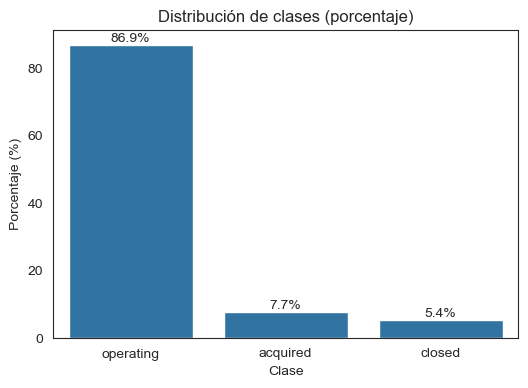

In [13]:
sns.set_style('white')
target = 'exito'


porcentajes = df[target].value_counts(normalize=True) * 100


plt.figure(figsize=(6,4))
ax = sns.barplot(x=porcentajes.index, y=porcentajes.values)
for i, v in enumerate(porcentajes.values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
ax.set_title("Distribuci√≥n de clases (porcentaje)")
ax.set_xlabel("Clase")
ax.set_ylabel("Porcentaje (%)")

plt.show()


In [14]:
df.head()

homepage_url  \
0         http://www.waywire.com   
1          http://enjoyandtv.com   
2   http://www.rockyourpaper.org   
3  http://www.InTouchNetwork.com   
4                            NaN   

                                       category_list         market  \
0         |Entertainment|Politics|Social Media|News|          News    
1                                            |Games|         Games    
2                             |Publishing|Education|    Publishing    
3  |Electronics|Guides|Coffee|Restaurants|Music|i...   Electronics    
4                      |Tourism|Entertainment|Games|       Tourism    

   funding_total_usd      exito country_code state_code         region  \
0          1750000.0   acquired          USA         NY  New York City   
1          4000000.0  operating          USA         CA    Los Angeles   
2            40000.0  operating          EST        NaN        Tallinn   
3          1500000.0  operating          GBR        NaN         London   
4            60000.0  operating          USA         TX         Dallas   

          city  funding_rounds founded_at founded_month founded_quarter  \
0     New York             1.0 2012-06-01    2012-06-01         2012-Q2   
1  Los Angeles             2.0        NaT           NaT             NaN   
2      Tallinn             1.0 2012-10-26    2012-10-01         2012-Q4   
3       London             1.0 2011-04-01    2011-04-01         2011-Q2   
4   Fort Worth             2.0 2014-01-01    2014-01-01         2014-Q1   

  founded_year first_funding_at last_funding_at       seed    venture  \
0   2012-01-01       2012-06-30      2012-06-30  1750000.0        0.0   
1          NaT       2010-06-04      2010-09-23        0.0  4000000.0   
2   2012-01-01       2012-08-09      2012-08-09    40000.0        0.0   
3   2011-01-01       2011-04-01      2011-04-01  1500000.0        0.0   
4   2014-01-01       2014-08-17      2014-09-26        0.0        0.0   

   equity_crowdfunding  undisclosed  convertible_note  angel  grant  \
0                  0.0          0.0               0.0    0.0    0.0   
1                  0.0          0.0               0.0    0.0    0.0   
2                  0.0          0.0               0.0    0.0    0.0   
3                  0.0          0.0               0.0    0.0    0.0   
4              60000.0          0.0               0.0    0.0    0.0   

   private_equity  secondary_market  product_crowdfunding  round_A  round_B  \
0             0.0               0.0                   0.0      0.0      0.0   
1             0.0               0.0                   0.0      0.0      0.0   
2             0.0               0.0                   0.0      0.0      0.0   
3             0.0               0.0                   0.0      0.0      0.0   
4             0.0               0.0                   0.0      0.0      0.0   

   round_C  round_D  round_E  round_F  round_G  round_H  
0      0.0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

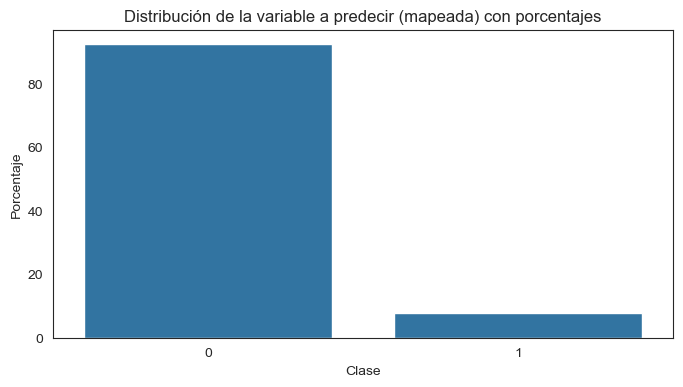

In [15]:
# target = 'exito'
# mapping = {'operating': 0, 'closed': 0, 'acquired': 1}
# df[target] = df[target].map(mapping)

# Calcular los porcentajes de cada clase en la variable 'exito'
# percentages = df[target].value_counts(normalize=True) * 100
mapping = {
    'acquired':  1,
    'closed':    0,
    'operating': 0,
    'ipo':       0
}
df['exito'] = df['exito'].map(mapping) \
                       .fillna(0) \
                       .astype(int)

# 2) Calcular porcentajes
percentages = df['exito'].value_counts(normalize=True) * 100 
# Crear el gr√°fico de barras con porcentajes
plt.figure(figsize=(8, 4))
sns.barplot(x=percentages.index, y=percentages.values)

# Configuraci√≥n del gr√°fico
plt.title('Distribuci√≥n de la variable a predecir (mapeada) con porcentajes')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')

plt.show

In [16]:
# Funci√≥n para agrupar por rangos
def year_group(row):
    year = row['founded_year'].year if pd.notnull(row['founded_year']) else None
    if year is None:
        return ''
    if 1900 <= year <= 1925:
        return 'less_than_1925'
    elif 1925 < year <= 1950:
        return '1925_1950'
    elif 1950 < year <= 1975:
        return '1950_1975'
    elif 1975 < year <= 2000:
        return '1975_2000'
    elif year > 2000:
        return '2000_2014'
    else:
        return ''

# Aplicar la funci√≥n
df['founded_year_group'] = df.apply(year_group, axis=1)

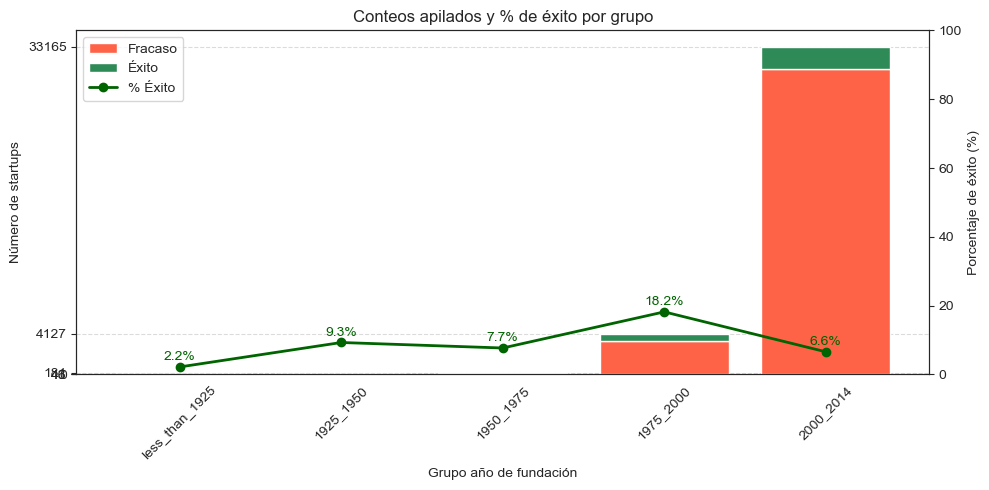

In [17]:
# 1) Preparar los datos
grouped = df.groupby('founded_year_group')['exito'].value_counts().unstack(fill_value=0)

ordered_groups = [
    'less_than_1925',
    '1925_1950',
    '1950_1975',
    '1975_2000',
    '2000_2014'
]

fails  = grouped.loc[ordered_groups, 0]
succs  = grouped.loc[ordered_groups, 1]
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)

# 2) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(10,5))

bar1 = ax1.bar(ordered_groups, fails,  label='Fracaso', color='tomato')
bar2 = ax1.bar(ordered_groups, succs, bottom=fails, label='√âxito',   color='seagreen')

# 3) Fijar los ticks del eje Y a los totales (y al 0)
yticks = np.concatenate([[0], totals.values])
ax1.set_yticks(sorted(yticks))
ax1.set_ylabel("N√∫mero de startups")
ax1.set_xlabel("Grupo a√±o de fundaci√≥n")
ax1.set_title("Conteos apilados y % de √©xito por grupo")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 4) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(ordered_groups, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% √âxito')
ax2.set_ylabel("Porcentaje de √©xito (%)")
ax2.set_ylim(0, 100)

# 5) Anotar % de √©xito encima de cada punto
for x, pct in zip(ordered_groups, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 6) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()


Se puede observar que casi todas las empresas se fundan entre el a√±o `2000` y `2014`. Por ello, ahora ploteamos la gr√°fica de solo los a√±os `2000` a `2014`.

¬° PENDIENTE DE ARREGLAR NO BORRAR ! (ARREGLAR LO DEL .dt.year ya que se ha cambiado el tipo de fecha)

In [18]:
# # 1) Filtrar los datos para a√±os de fundaci√≥n >= 2000
# # Aseg√∫rate de que la columna est√° en formato datetime
# df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# # Filtrar usando el a√±o extra√≠do
# df_new = df[df['founded_year'].dt.year >= 2000].copy()

# # Convertir 'founded_year' a solo el a√±o como entero para graficar
# df_new['founded_year'] = df_new['founded_year'].dt.year


# # 2) Preparar los datos agrupados por a√±o de fundaci√≥n
# grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

# fails = grouped.get(0, pd.Series(dtype=int))
# succs = grouped.get(1, pd.Series(dtype=int))
# totals = fails + succs
# pct_succs = (succs / totals * 100).round(1)
# years = grouped.index.tolist()

# # 3) Dibujar las barras apiladas
# fig, ax1 = plt.subplots(figsize=(12, 6))

# bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
# bar2 = ax1.bar(years, succs, bottom=fails, label='√âxito', color='seagreen')

# # 4) Fijar las etiquetas del eje X a todos los a√±os
# ax1.set_xticks(years)
# ax1.set_ylabel("N√∫mero de startups")
# ax1.set_xlabel("A√±o de fundaci√≥n")
# ax1.set_title("Conteos apilados y % de √©xito por a√±o (>= 2000)")
# ax1.tick_params(axis='x', rotation=45)

# # El eje Y ahora usar√° los ticks predeterminados de Matplotlib
# ax1.grid(axis='y', linestyle='--', alpha=0.7)

# # 5) Eje secundario de porcentaje
# ax2 = ax1.twinx()
# ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% √âxito')
# ax2.set_ylabel("Porcentaje de √©xito (%)")
# ax2.set_ylim(0, 100)

# # 6) Anotar % de √©xito encima de cada punto
# for x, pct in zip(years, pct_succs):
#     ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# # 7) Leyenda combinada
# h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# plt.tight_layout()
# plt.show()

Sin embargo, el intervalo de tiempo en el que las empresas tienen mayor √©xito (en proporci√≥n) es entre `1975` y el a√±o `2000`, por lo que mostramos tambi√©n su gr√°fica.

¬° PENDIENTE DE ARREGLAR NO BORRAR ! (ARREGLAR LO DEL .dt.year ya que se ha cambiado el tipo de fecha)

In [19]:
# # 1) Filtrar los datos para a√±os de fundaci√≥n >= 2000
# # Aseg√∫rate de que 'founded_year' est√° en formato datetime
# df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# # Extrae el a√±o como entero y filtra
# df_new = df[
#     (df['founded_year'].dt.year >= 1975) &
#     (df['founded_year'].dt.year <= 2000)
# ].copy()

# # Crea la nueva columna como enteros para graficar
# df_new['founded_year'] = df_new['founded_year'].dt.year

# # 2) Preparar los datos agrupados por a√±o de fundaci√≥n
# grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

# fails = grouped.get(0, pd.Series(dtype=int))
# succs = grouped.get(1, pd.Series(dtype=int))
# totals = fails + succs
# pct_succs = (succs / totals * 100).round(1)
# years = grouped.index.tolist()

# # 3) Dibujar las barras apiladas
# fig, ax1 = plt.subplots(figsize=(12, 6))

# bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
# bar2 = ax1.bar(years, succs, bottom=fails, label='√âxito', color='seagreen')

# # 4) Fijar las etiquetas del eje X a todos los a√±os
# ax1.set_xticks(years)
# ax1.set_ylabel("N√∫mero de startups")
# ax1.set_xlabel("A√±o de fundaci√≥n")
# ax1.set_title("Conteos apilados y % de √©xito por a√±o (>= 1975 y <= 2000)")
# ax1.tick_params(axis='x', rotation=45)

# # El eje Y ahora usar√° los ticks predeterminados de Matplotlib
# ax1.grid(axis='y', linestyle='--', alpha=0.7)

# # 5) Eje secundario de porcentaje
# ax2 = ax1.twinx()
# ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% √âxito')
# ax2.set_ylabel("Porcentaje de √©xito (%)")
# ax2.set_ylim(0, 100)

# # 6) Anotar % de √©xito encima de cada punto
# for x, pct in zip(years, pct_succs):
#     ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# # 7) Leyenda combinada
# h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# plt.tight_layout()
# plt.show()

### An√°lisis de la intensidad de financiaci√≥n

En este bloque de c√≥digo vamos a explorar c√≥mo el monto total de financiaci√≥n recibido por cada startup se relaciona con su probabilidad de √©xito:

1. **Discretizaci√≥n en intervalos**  
   - Definimos una serie de rangos (bins) que agrupan las startups seg√∫n franjas de inversi√≥n (por ejemplo, `<100K`, `100K‚Äì1M`, etc.).

2. **C√°lculo de √©xitos y fracasos**  
   - Agrupamos el n√∫mero de startups adquiridas (`exito = 1`) y no adquiridas (`exito = 0`) en cada intervalo.

3. **Visualizaci√≥n**  
   - Generamos un gr√°fico de barras **apiladas** para mostrar el conteo de √©xitos y fracasos por intervalo.  
   - Sobre el mismo eje, trazamos una **l√≠nea** que indica el porcentaje de √©xito dentro de cada rango de financiaci√≥n.

Este an√°lisis nos ayuda a identificar de manera intuitiva si existe alg√∫n umbral de inversi√≥n por encima del cual las startups muestran una mayor probabilidad de ser adquiridas.


C:\Users\marti\AppData\Local\Temp\ipykernel_20472\2200369026.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('fnd_bin')['exito']


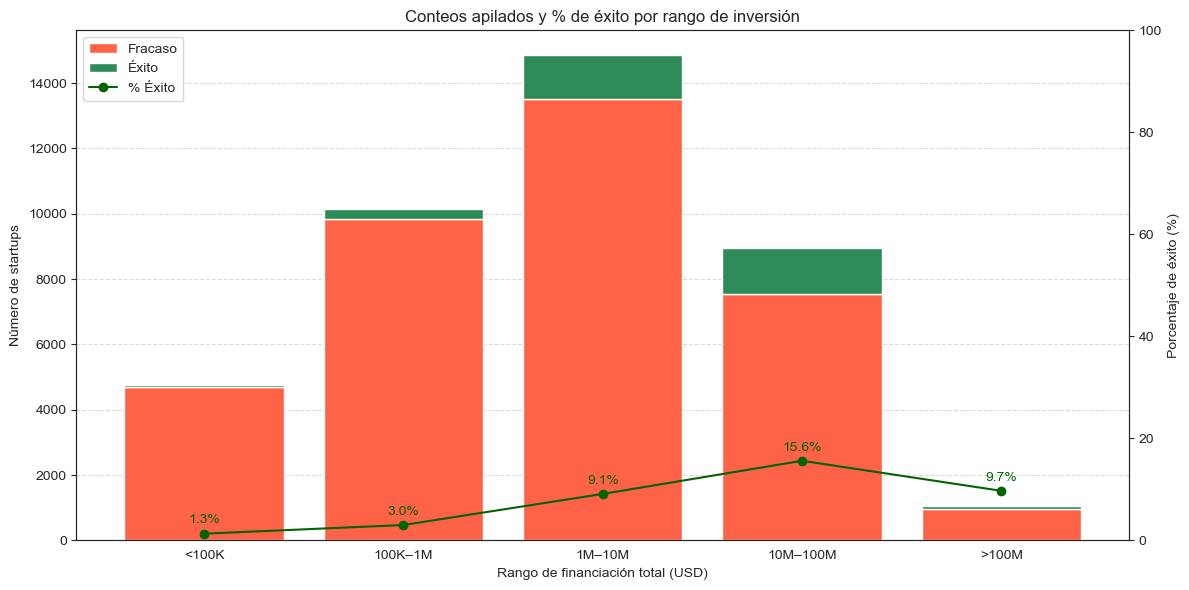

In [20]:
# 1) LIMPIEZA Y CONVERSI√ìN de funding_total_usd
df['funding_total_usd'] = (
    df['funding_total_usd']
      .astype(str)
      .str.replace(',', '', regex=False)
)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df = df.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS
bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
labels = ['<100K', '100K‚Äì1M', '1M‚Äì10M', '10M‚Äì100M', '>100M']
df['fnd_bin'] = pd.cut(
    df['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR √âXITOS/FRACASOS (**sin volver a remapear exito**)
grouped = (
    df
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(labels, fill_value=0)
)

fails = grouped[0]
succs = grouped[1]
totals = fails + succs
pct    = (succs / totals * 100).round(1).fillna(0)

# 4) PLOT Apilado + L√≠nea de %
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(labels, fails,  color='tomato',    label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='√âxito')
ax1.set_xlabel("Rango de financiaci√≥n total (USD)")
ax1.set_ylabel("N√∫mero de startups")
ax1.set_title("Conteos apilados y % de √©xito por rango de inversi√≥n")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% √âxito')
ax2.set_ylabel("Porcentaje de √©xito (%)")
ax2.set_ylim(0, 100)

for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

¬° PENDIENTE DE ARREGLAR NO BORRAR ! (ARREGLAR LO DEL .dt.year ya que se ha cambiado el tipo de fecha)

In [21]:
# # Convertir a datetime (si a√∫n no lo has hecho)
# df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# # Crear una nueva columna con el a√±o como entero
# df['founded_year_int'] = df['founded_year'].dt.year

# # Filtrar usando el a√±o como entero
# df = df[df['founded_year_int'] >= 1990].copy()

# df = df.dropna(subset=['funding_total_usd']).copy()

# # 2) DEFINIR BINS Y ETIQUETAS
# bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
# labels = ['<100K', '100K‚Äì1M', '1M‚Äì10M', '10M‚Äì100M', '>100M']

# df['fnd_bin'] = pd.cut(
#     df['funding_total_usd'],
#     bins=bins,
#     labels=labels,
#     right=False,
#     include_lowest=True
# )

# # 3) AGRUPAR √âXITOS/FRACASOS y manejar valores ausentes
# grouped = (
#     df
#     .groupby('fnd_bin')['exito']
#     .value_counts()
#     .unstack(fill_value=0)  # Asegura que los valores vac√≠os se rellenen con 0
# )

# # Reindexar para asegurarse de que todos los bins est√©n presentes, incluso si no hay datos para alguno
# grouped = grouped.reindex(labels, fill_value=0)

# # Ahora obtenemos las m√©tricas
# fails = grouped[0]  # Fracasos
# succs = grouped[1]  # √âxitos
# totals = fails + succs  # Total de startups por bin
# pct = (succs / totals * 100).round(1).fillna(0)  # Porcentaje de √©xito

# # 4) PLOT Apilado + L√≠nea de %
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Crear gr√°fico apilado
# ax1.bar(labels, fails, color='tomato', label='Fracaso')
# ax1.bar(labels, succs, bottom=fails, color='seagreen', label='√âxito')
# ax1.set_xlabel("Rango de financiaci√≥n total (USD)")
# ax1.set_ylabel("N√∫mero de startups")
# ax1.set_title("Conteos apilados y % de √©xito por rango de inversi√≥n")
# ax1.grid(axis='y', linestyle='--', alpha=0.7)

# # Crear el eje para la l√≠nea de porcentaje
# ax2 = ax1.twinx()
# ax2.plot(labels, pct, color='darkgreen', marker='o', label='% √âxito')
# ax2.set_ylabel("Porcentaje de √©xito (%)")
# ax2.set_ylim(0, 100)

# # A√±adir etiquetas de porcentaje sobre la l√≠nea
# for x, p in zip(labels, pct):
#     ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

# # Unir las leyendas de ambos gr√°ficos
# h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# # Ajustar el dise√±o para evitar superposiciones
# plt.tight_layout()
# plt.show()


### Impacto del n√∫mero de rondas de financiaci√≥n

Este gr√°fico muestra c√≥mo el n√∫mero de rondas de financiaci√≥n influye en la probabilidad de adquisici√≥n:

1. **Conteos apilados**  
   - Barras rojas (`Fracaso`): startups no adquiridas.  
   - Barras verdes (`√âxito`): startups adquiridas.  

2. **Porcentaje de √©xito**  
   - L√≠nea y marcadores en verde oscuro indican el porcentaje de startups adquiridas por cada n√∫mero de rondas.  

Con este an√°lisis podemos ver si m√°s rondas de financiaci√≥n se traducen en una mayor tasa de adquisiciones.  


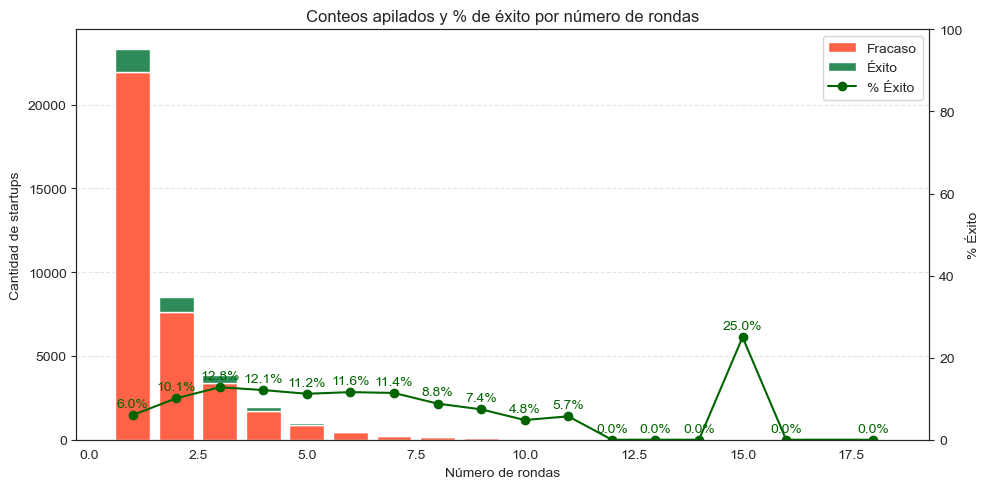

In [22]:
# 1) Agrupamos por n√∫mero de rondas y exito
grp2 = (
    df.groupby('funding_rounds')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .sort_index()
)
fails2 = grp2.get(0, pd.Series(dtype=int))
succs2 = grp2.get(1, pd.Series(dtype=int))
rnds   = fails2.index
tot2   = fails2 + succs2
pct2   = (succs2 / tot2 * 100).round(1)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(rnds, fails2,  color='tomato',    label='Fracaso')
ax1.bar(rnds, succs2, bottom=fails2, color='seagreen', label='√âxito')
ax1.set_xlabel("N√∫mero de rondas")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("Conteos apilados y % de √©xito por n√∫mero de rondas")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(rnds, pct2, color='darkgreen', marker='o', label='% √âxito')
ax2.set_ylabel("% √âxito")
ax2.set_ylim(0,100)

for x, p in zip(rnds, pct2):
    ax2.text(x, p+2, f"{p}%", ha='center', color='darkgreen')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()
plt.show()


### Combinaci√≥n Sector‚ÄìPa√≠s (Top 5√óTop 5)

Este gr√°fico muestra c√≥mo se distribuyen las startups en los 5 sectores m√°s frecuentes y los 5 pa√≠ses principales:

1. **Barras apiladas**  
   - Cada barra representa un sector.  
   - Los segmentos apilados (colores) corresponden al n√∫mero de startups en cada pa√≠s.  

2. **L√≠nea de porcentaje de √©xito**  
   - L√≠nea negra con marcadores muestra el porcentaje medio de adquisiciones por sector, considerando todos los pa√≠ses.  

Este an√°lisis permite ver, de un vistazo, en qu√© combinaciones sector‚Äìpa√≠s se concentra el mayor volumen de startups y cu√°les tienen la mayor tasa de √©xito.  


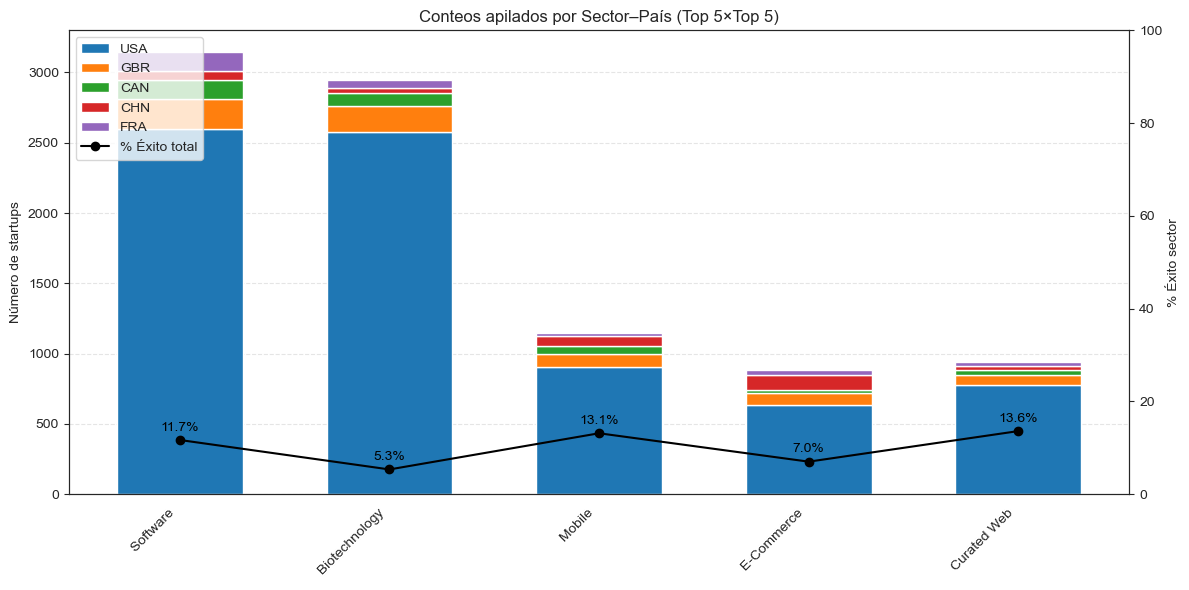

In [23]:
# 1) Filtramos top 5 de cada uno
top_secures   = df['market'].value_counts().head(5).index
top_countries = df['country_code'].value_counts().head(5).index
sub = df[df['market'].isin(top_secures) & df['country_code'].isin(top_countries)]

# 2) Pivot counts y % √©xito
pivot_cnt = sub.pivot_table(
    index='market', columns='country_code', values='exito',
    aggfunc=['count','mean']
)
cnts = pivot_cnt['count']
pcts = (pivot_cnt['mean'] * 100).round(1)

# 3) Para cada sector dibujamos barras apiladas por pa√≠s y % l√≠nea
fig, ax1 = plt.subplots(figsize=(12,6))
width = 0.6
x = np.arange(len(top_secures))

# apilado
bottom = np.zeros(len(top_secures))
for c in top_countries:
    vals = cnts[c].reindex(top_secures).fillna(0)
    ax1.bar(x, vals, width, bottom=bottom, label=c)
    bottom += vals

ax1.set_xticks(x)
ax1.set_xticklabels(top_secures, rotation=45, ha='right')
ax1.set_ylabel("N√∫mero de startups")
ax1.set_title("Conteos apilados por Sector‚ÄìPa√≠s (Top 5√óTop 5)")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# l√≠nea de % √©xito promedio por sector (sobre todos los pa√≠ses)
avg_pct = sub.groupby('market')['exito'].mean().reindex(top_secures) * 100
ax2 = ax1.twinx()
ax2.plot(x, avg_pct, color='black', marker='o', label='% √âxito total')
ax2.set_ylabel("% √âxito sector")
ax2.set_ylim(0,100)

for xi, p in zip(x, avg_pct):
    ax2.text(xi, p+2, f"{p:.1f}%", ha='center', color='black')

# leyenda combinada
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

plt.tight_layout()
plt.show()


### Top 25 Categor√≠as de Mercado y √âxito

Este gr√°fico muestra las **25 categor√≠as m√°s frecuentes** de startups y su **porcentaje de √©xito** (startups adquiridas):

1. **Barras**: representan el porcentaje de startups por categor√≠a.  
2. **Color secundario**: indica el porcentaje de √©xito en cada una.

Permite comparar la popularidad de cada categor√≠a con su tasa de adquisici√≥n.

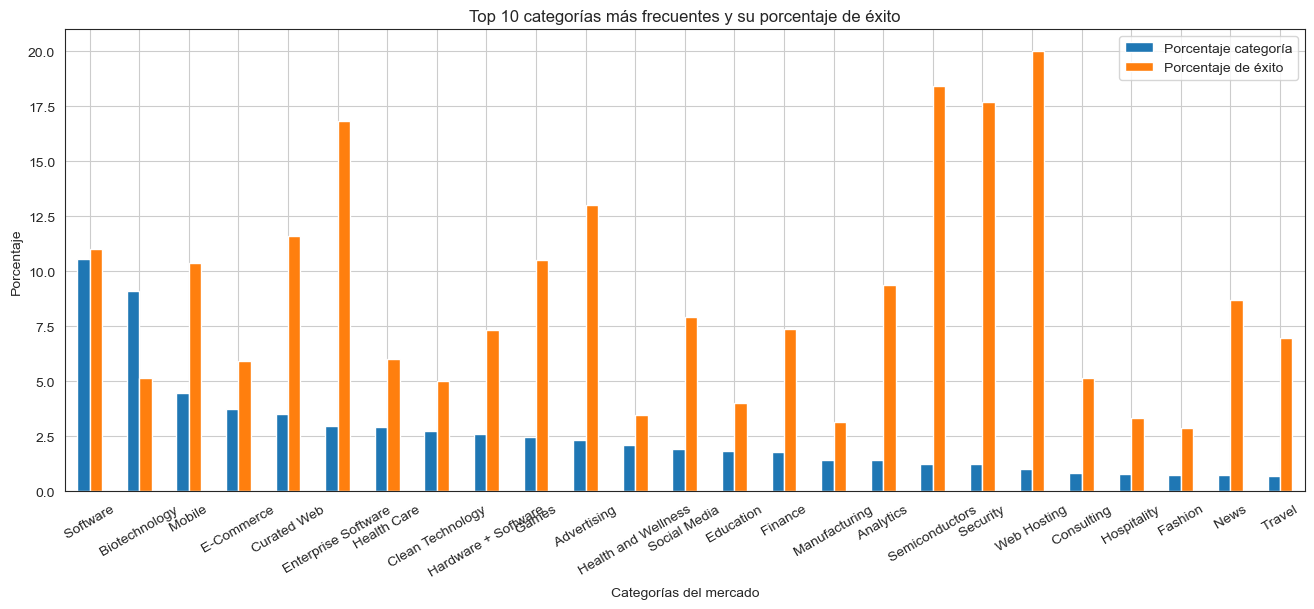

In [24]:
market_counts = df['market'].value_counts(normalize=True) * 100

# Calcular el porcentaje de 'exito = 1' para cada categor√≠a en 'market'
success_percentage = df.groupby('market')['exito'].mean() * 100

# Crear un DataFrame con los porcentajes de las categor√≠as y el porcentaje de √©xito
result_df = pd.DataFrame({
    'Porcentaje categor√≠a': market_counts,
    'Porcentaje de √©xito': success_percentage
})

# Seleccionar las 10 categor√≠as m√°s frecuentes
top_categories = market_counts.head(25)

# Filtrar el DataFrame resultante para mostrar solo las categor√≠as m√°s frecuentes
result_df_top = result_df.loc[top_categories.index]

# Graficar
result_df_top.plot(kind='bar', figsize=(16, 6))

plt.title('Top 10 categor√≠as m√°s frecuentes y su porcentaje de √©xito')
plt.xlabel('Categor√≠as del mercado')
plt.ylabel('Porcentaje')
plt.xticks(rotation=30)
plt.grid()
plt.show()

Se puede observar que el n√∫mero de startups **aumenta** cada a√±o.

C:\Users\marti\AppData\Local\Temp\ipykernel_20472\641170365.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100


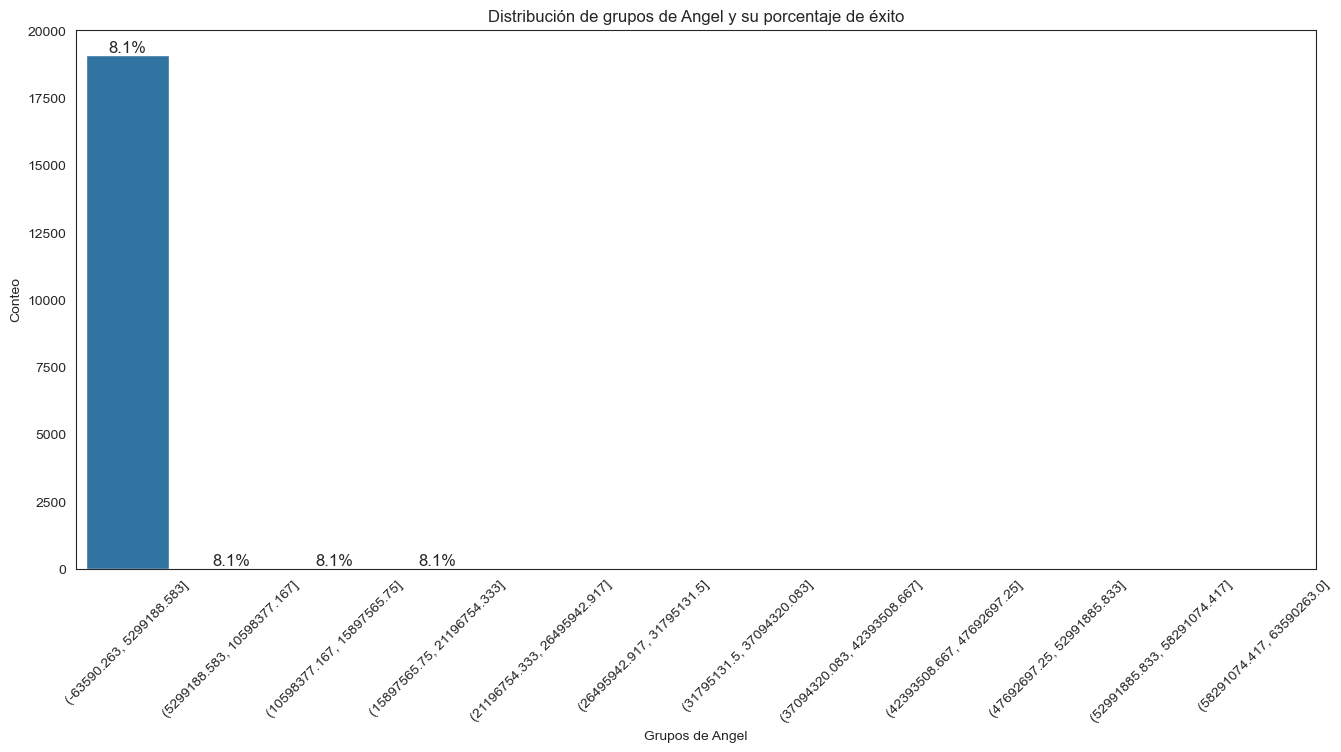

In [25]:
# Dividir la variable 'angel' en 12 grupos utilizando pd.cut
df['angel_group'] = pd.cut(df['angel'], bins=12)

# Calcular el porcentaje de 'exito = 1' para cada grupo en 'angel_group'
success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100

# Graficar la distribuci√≥n de 'angel_group'
plt.figure(figsize=(16, 7))

# Gr√°fico de barras con el conteo de cada grupo en 'angel_group'
sns.countplot(x='angel_group', data=df.dropna())

# A√±adir los porcentajes de √©xito encima de las barras
for p in plt.gca().patches:
    height = p.get_height()
    # Obtener el grupo de 'angel_group' correspondiente
    group_label = p.get_x() + p.get_width() / 2
    group_label = df['angel_group'].iloc[int(group_label)]  # Identificar la categor√≠a por √≠ndice
    
    # A√±adir el texto con el porcentaje de √©xito en el gr√°fico
    plt.text(p.get_x() + p.get_width() / 2, height + 1, f'{success_percentage_angel_group[group_label]:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribuci√≥n de grupos de Angel y su porcentaje de √©xito')
plt.xlabel('Grupos de Angel')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()


Podemos observar que casi todas las startups son de `Software` y `Biotechnology`, seguidas de `Mobile`,`E-Commerce` y `Curated Webs`.

Realizamos un an√°lisis de la variable a predecir en este caso, exito.

De momento vamos a asignar, la clase 1 a acquired y 0 a closed. Pero podr√≠amos realizar otra distribuci√≥n de clases si fuera de inter√©s para el trabajo

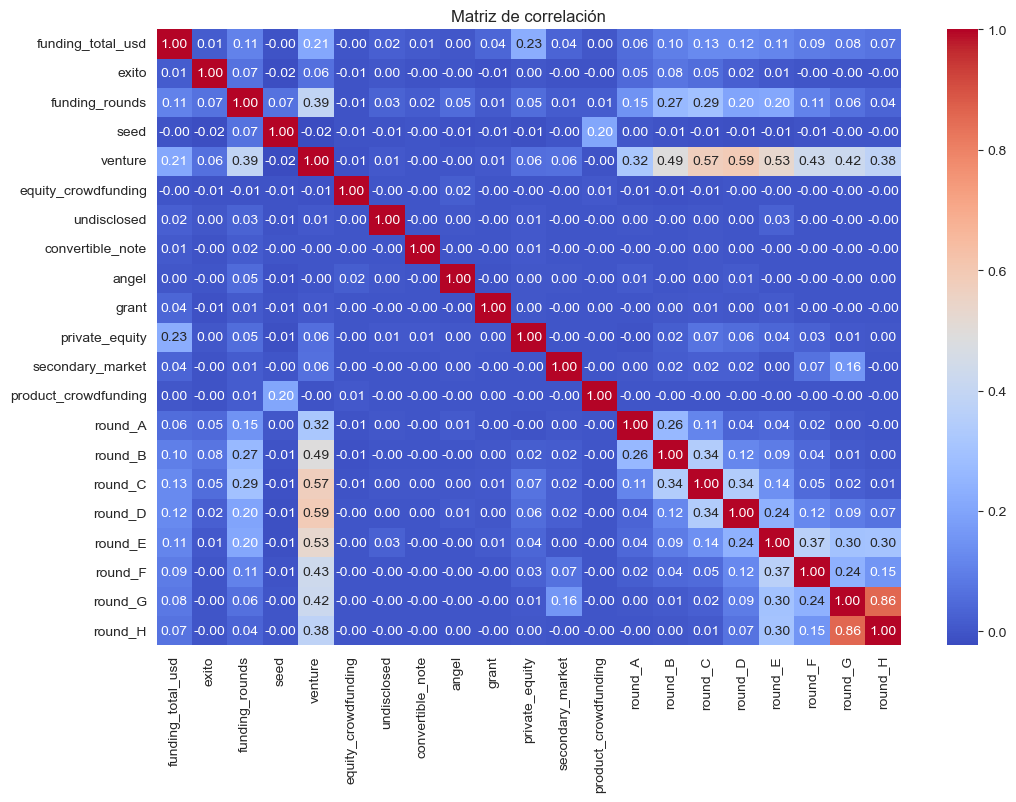

In [26]:
# Creamos una matriz de correlaci√≥n entre las variables num√©ricas
numerical_df = df.select_dtypes(include=['number']) 
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlaci√≥n')
plt.show()

Text(0.5, 1.0, 'Relaci√≥n entre funding_rounds, founded_year y exito')

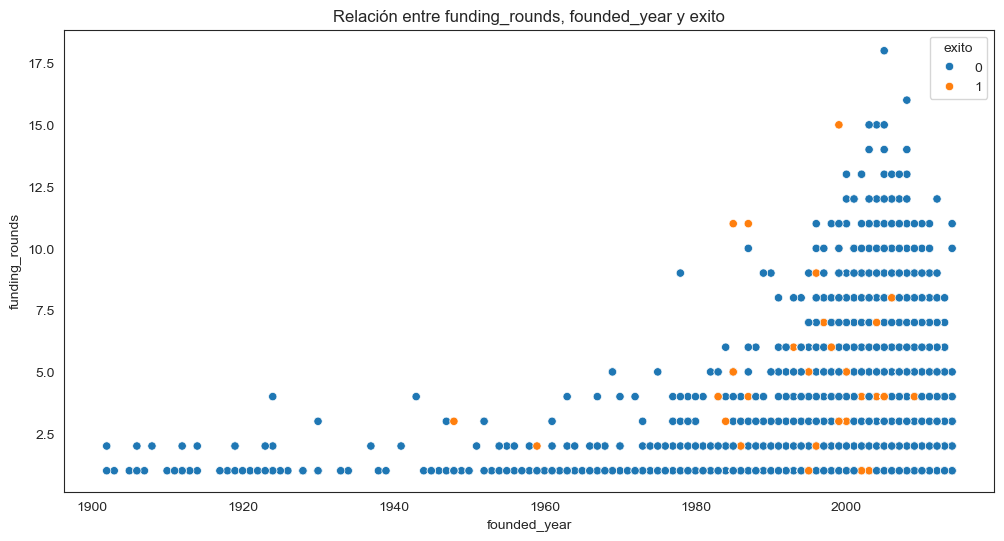

In [27]:
# Observamos que variables que est√°n m√°s correlacionadas con la variable de salida son funding_round y founded_year
# Observamos relacion entre funding_round, founded_year y variable objetivo 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='founded_year', y='funding_rounds', hue='exito')
plt.title('Relaci√≥n entre funding_rounds, founded_year y exito')

M√°s rondas de financiaci√≥n aumentan la probabilidad de salida: Las startups con m√°s rondas de financiaci√≥n (4 o m√°s) tienen mayor probabilidad de ser "adquiridas" o "cerradas" en comparaci√≥n con aquellas con menos rondas (1-3), que suelen estar "operando". Esto sugiere que una financiaci√≥n sostenida aumenta las posibilidades de un evento de salida.

C:\Users\marti\AppData\Local\Temp\ipykernel_20472\3909155556.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)


<Figure size 1000x600 with 0 Axes>

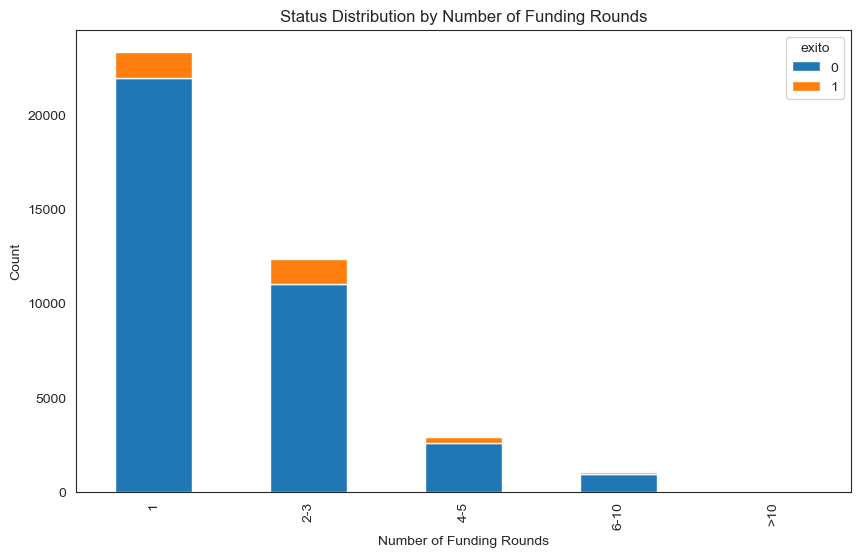

In [28]:
# Relationship 1: More Funding Rounds Increase Exit Likelihood
plt.figure(figsize=(10, 6))
df['funding_rounds_bin'] = pd.cut(df['funding_rounds'], bins=[0, 1, 3, 5, 10, float('inf')],
                                 labels=['1', '2-3', '4-5', '6-10', '>10'])
status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)
status_rounds.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Status Distribution by Number of Funding Rounds')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Count')
plt.legend(title='exito')
plt.show()


Mayores cantidades de financiaci√≥n se correlacionan con adquisiciones: Las startups adquiridas tienen una mediana de financiaci√≥n m√°s alta ($10M) en comparaci√≥n con las cerradas y las que est√°n operando ($1M), lo que indica que m√°s financiaci√≥n aumenta la probabilidad de adquisici√≥n, mientras que menos financiaci√≥n puede llevar al cierre.

<Figure size 1000x600 with 0 Axes>

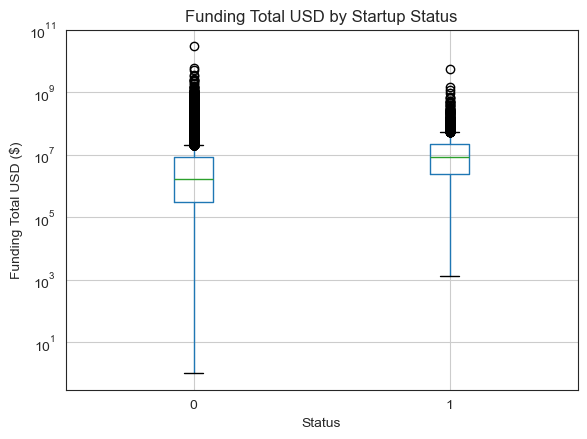

In [29]:
# Relationship 2: Higher Funding Amounts Correlate with Acquisitions
plt.figure(figsize=(10, 6))
df.boxplot(column='funding_total_usd', by='exito', showfliers=True)
plt.title('Funding Total USD by Startup Status')
plt.suptitle('')
plt.xlabel('Status')
plt.ylabel('Funding Total USD ($)')
plt.yscale('log')
plt.show()


La edad de la startup afecta su estado: Las startups m√°s nuevas (post-2010) est√°n mayormente "operando", mientras que las m√°s antiguas (pre-2005) tienen m√°s estados "adquiridas" y "cerradas". El per√≠odo 2005-2010 muestra una mezcla equilibrada, sugiriendo que 5-15 a√±os tras la fundaci√≥n es un per√≠odo cr√≠tico para salidas.


# Relationship 3: Startup Age Affects Status


Tendencias de financiaci√≥n a lo largo del tiempo: La financiaci√≥n total alcanz√≥ su pico alrededor de 2010-2015, reflejando un auge en la inversi√≥n en startups, mientras que el n√∫mero promedio de rondas de financiaci√≥n por startup se mantiene estable (1-2.5). Nota: Las tendencias antes de 1980 fueron excluidas debido a problemas de calidad de datos.

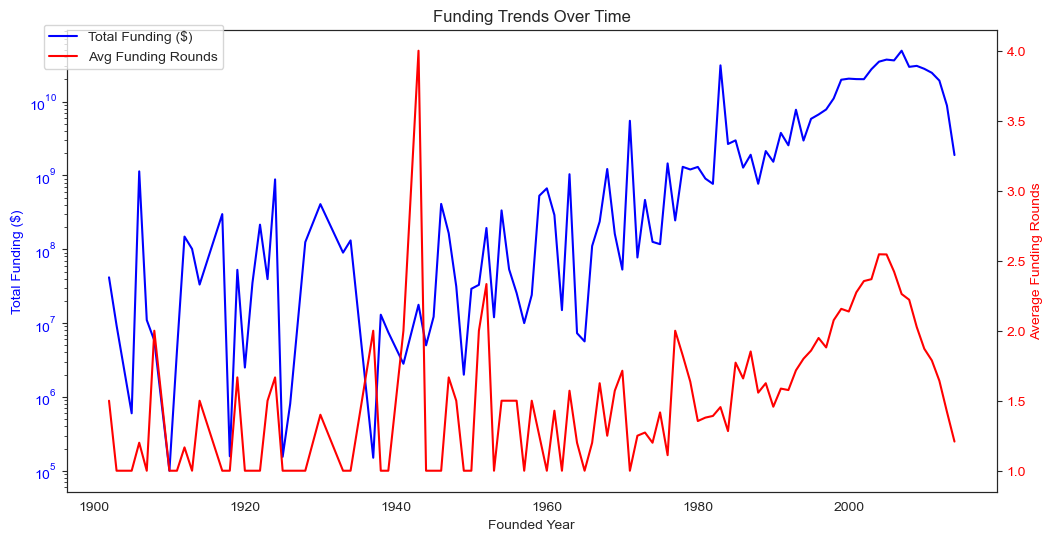

In [30]:

# Relationship 5: Funding Trends Over Time
df_yearly = df.groupby('founded_year').agg({
    'funding_total_usd': 'sum',
    'funding_rounds': 'mean'
}).reset_index()
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_yearly['founded_year'], df_yearly['funding_total_usd'], 'b-', label='Total Funding ($)')
ax1.set_xlabel('Founded Year')
ax1.set_ylabel('Total Funding ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.plot(df_yearly['founded_year'], df_yearly['funding_rounds'], 'r-', label='Avg Funding Rounds')
ax2.set_ylabel('Average Funding Rounds', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Funding Trends Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 4. Preparaci√≥n de los datos para clasificaci√≥n simple
Para poder realizar predicciones al principio, tenemos que lidiar con valores nulos primero realizaremos un analisis sencillo y los ignoraremos o sustituiremos, posteriormente usaremos tecnicas de imputacion y similares para intentar no perder informacion relevante.

Posteriormente aplicaremos una pipeline sencilla con knn para una primera clasificacion simple del problema

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

print("Valores √∫nicos en df['exito'] antes del mapeo:")
print(df['exito'].unique())
# Aseg√∫rate de partir del DataFrame correcto

X = df.drop(columns=['exito'])
y = df['exito']

# Separar columnas (ya tienes X definido)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5))
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipeline completa con Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
#resultados = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline, beta=0.7)


Valores √∫nicos en df['exito'] antes del mapeo:
[1 0]


In [32]:
# === 1. Separar variables
X = df.drop(columns=['exito'])
y = df['exito']

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# === 3. Pipeline de preprocesamiento + modelo
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5))
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# === 4. Dividir el conjunto (hold-out 70/30)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# === 5. Ejecutar evaluaci√≥n
resultados = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)


==== Evaluaci√≥n del modelo ====
F0.7-score: 0.0878
AUC-PR:      0.1326


### Limpiar data

Primero eliminamos las variables que sean creado para poder visualizar las gr√°ficas.

In [33]:
# Lista de las columnas de EDA que quieres eliminar
cols_to_drop = [
    'founded_year_group',
    'fnd_bin',
    'angel_group',
    'funding_rounds_bin'
]

# Opci√≥n A: borrarlas directamente del df original
df.drop(columns=cols_to_drop, inplace=True)

df['founded_year'] =  pd.to_datetime(df['founded_year'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors

## 5. Imputaci√≥n de valores perdidos

In [34]:
# Divisi√≥n inicial: 60% entrenamiento, 40% restante
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Divisi√≥n secundaria: 50% validaci√≥n, 50% prueba del 40% restante
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Tama√±os de los conjuntos: \nEntrenamiento: {X_train.shape}, Validaci√≥n: {X_val.shape}, Prueba: {X_test.shape}")

Tama√±os de los conjuntos: 
Entrenamiento: (23851, 37), Validaci√≥n: (7950, 37), Prueba: (7951, 37)


### Imputaci√≥n de ``founded_year`` usando KNNImputer

#### Elecci√≥n de la imputaci√≥n frente a la eliminaci√≥n de valores

En nuestro conjunto de datos, la columna ``founded_year`` contiene m√°s de 10.000 registros faltantes. Eliminar una cantidad tan significativa de filas podr√≠a suponer una gran p√©rdida de informaci√≥n y sesgar potencialmente el an√°lisis. Imputar estos valores, especialmente al tratarse de a√±os, es una decisi√≥n razonable ya que preserva la integridad y el tama√±o del dataset.

#### ¬øPor qu√© usar KNNImputer?

Utilizamos ``KNNImputer`` porque permite estimar los a√±os faltantes considerando la similitud entre las observaciones. Este m√©todo parte de la suposici√≥n de que las empresas fundadas en a√±os cercanos pueden compartir caracter√≠sticas similares en otras variables, lo que convierte a KNN en una opci√≥n pr√°ctica para completar los valores ausentes de ``founded_year``.

#### Preparaci√≥n de los datos e imputaci√≥n

Antes de realizar la imputaci√≥n, la columna ``founded_year`` debe convertirse de tipo fecha a formato entero para cumplir con los requisitos de ``KNNImputer``. Luego, aplicamos la imputaci√≥n utilizando los vecinos m√°s cercanos, asegurando que nuestros datos sigan siendo consistentes y √∫tiles para el an√°lisis posterior.

In [35]:
print("Distribuci√≥n completa:", df['exito'].value_counts())

Distribuci√≥n completa: exito
0    36534
1     3218
Name: count, dtype: int64


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_recall_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ========================
# 1. Dataset SIN imputaci√≥n
# ========================
df_base = df.copy()

X_base = df_base.drop(columns='exito')
y_base = df_base['exito']

num_cols = ['founded_year']
cat_cols = []  # puedes a√±adir categ√≥ricas si usas alguna

preprocessor_base = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline_base = ImbPipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [37]:
# ========================
# 2. Dataset CON imputaci√≥n KNN
# ========================
df_knn = df.copy()

# Convertir a datetime si no lo es
if not pd.api.types.is_datetime64_any_dtype(df_knn['founded_year']):
    df_knn['founded_year'] = pd.to_datetime(df_knn['founded_year'], errors='coerce', format='%Y')

print("After conversion, null values:", df_knn['founded_year'].isnull().sum())

# Extraer a√±o
df_knn['founded_year'] = df_knn['founded_year'].dt.year

# Imputaci√≥n KNN
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_knn['founded_year'] = imputer.fit_transform(df_knn[['founded_year']]).round()

print("Null values after imputation:", df_knn['founded_year'].isnull().sum())

# Rellenar otras columnas si es necesario
cols_fill_zero = [
    'convertible_note', 'angel', 'grant', 'private_equity',
    'secondary_market', 'product_crowdfunding', 'round_A','round_B',
    'round_C', 'round_D', 'round_E', 'round_F', 'round_G','round_H'
]
df_knn[cols_fill_zero] = df_knn[cols_fill_zero].fillna(0)

After conversion, null values: 8378
Null values after imputation: 0


#### 5.1 Validaci√≥n

In [38]:
X_knn = df_knn.drop(columns='exito')
y_knn = df_knn['exito']

preprocessor_knn = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline_knn = ImbPipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
# ========================
# 3. Evaluaci√≥n
# ========================
puntuacion_sin_imputar = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline_base)
puntuacion_con_imputar = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline_knn)

print("Sin imputar:")
print(puntuacion_sin_imputar)

print("Con imputaci√≥n KNN:")
print(puntuacion_con_imputar)

==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1932
AUC-PR:      0.1486
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1932
AUC-PR:      0.1486
Sin imputar:
{'f_beta': np.float64(0.1932289212162074), 'AUC-PR': np.float64(0.14855039765246508)}
Con imputaci√≥n KNN:
{'f_beta': np.float64(0.1932289212162074), 'AUC-PR': np.float64(0.14855039765246508)}


## 6. Deteccion de outliers

### An√°lisis de valores at√≠picos

En esta parte nos centramos en analizar los **valores at√≠picos** dentro de las variables num√©ricas del dataset, especialmente aquellas que tienen que ver con las **rondas de financiaci√≥n**.

Para ello, usamos **boxplots** que nos permiten detectar de forma visual qu√© observaciones se alejan mucho del resto. Estos gr√°ficos son √∫tiles para hacernos una idea general de c√≥mo se distribuyen los datos y si hay valores extremos.

Sabemos que, en este tipo de datos, algunos outliers pueden ser simplemente **errores o datos mal introducidos**, pero otros pueden representar **casos reales pero extremos**, como startups que han recibido cantidades muy grandes de financiaci√≥n. Por eso, en vez de eliminar autom√°ticamente estos valores, decidimos evaluarlos seg√∫n el **contexto del problema**.

Este an√°lisis nos permite **decidir si eliminamos o ajustamos esos valores**, con el objetivo de que no distorsionen los modelos, pero sin perder informaci√≥n relevante. De esta forma, conseguimos que los datos con los que entrenamos los modelos sean m√°s fiables.


In [39]:
print("Distribuci√≥n completa:", df['exito'].value_counts())

Distribuci√≥n completa: exito
0    36534
1     3218
Name: count, dtype: int64


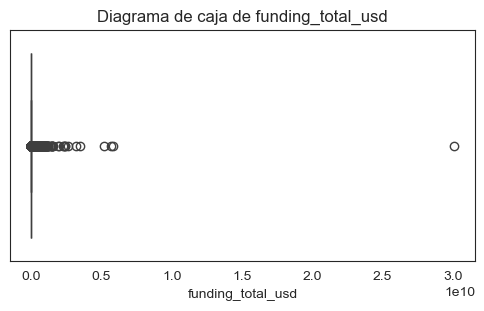

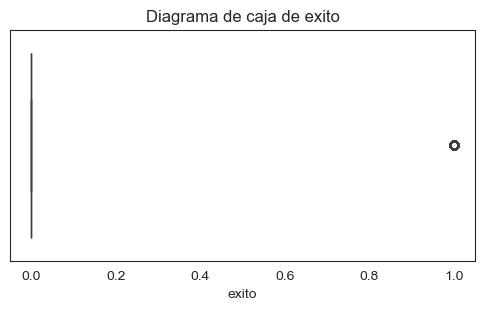

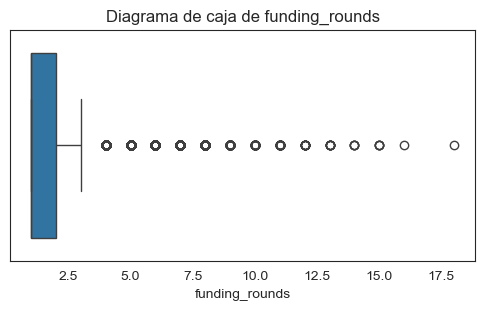

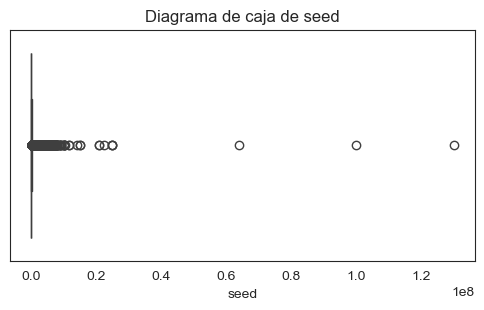

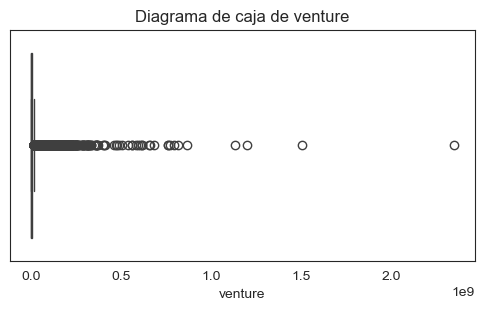

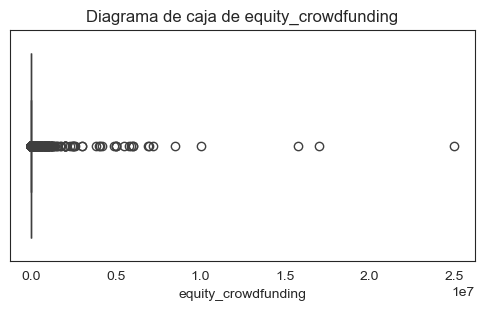

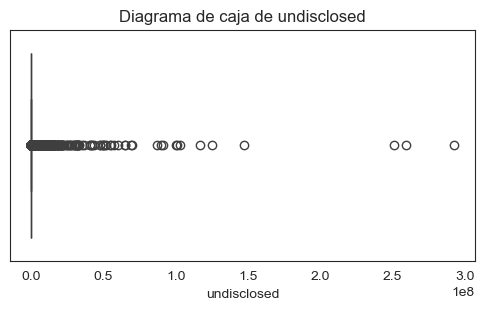

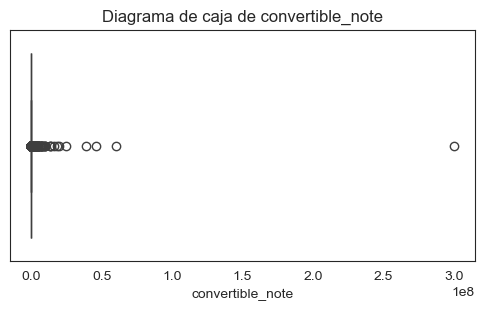

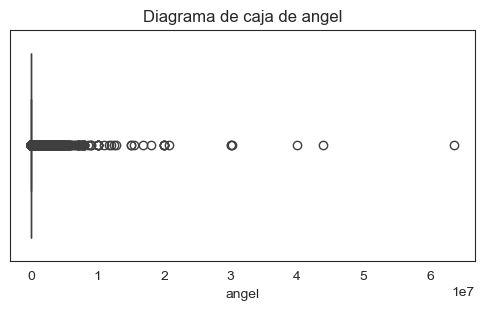

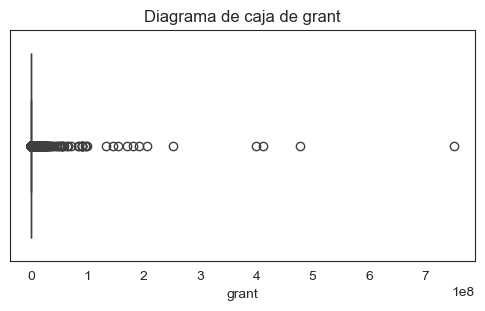

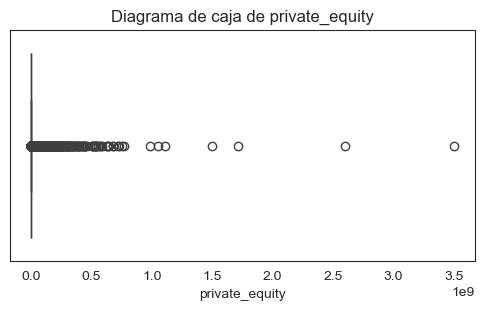

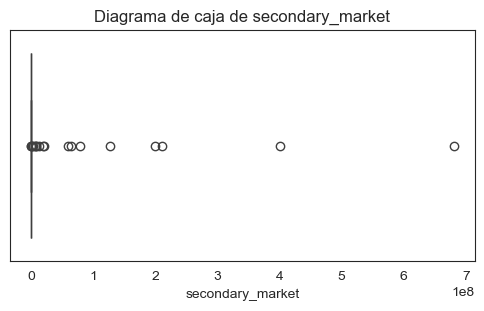

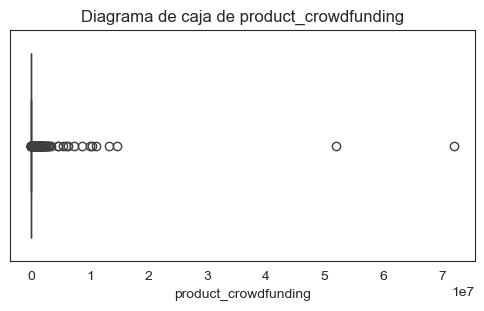

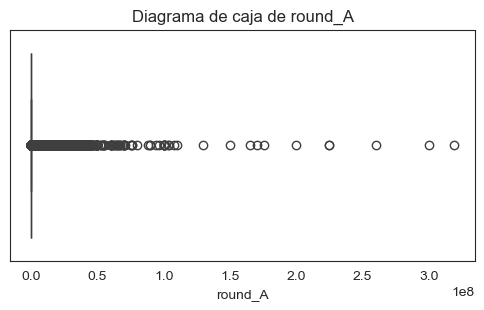

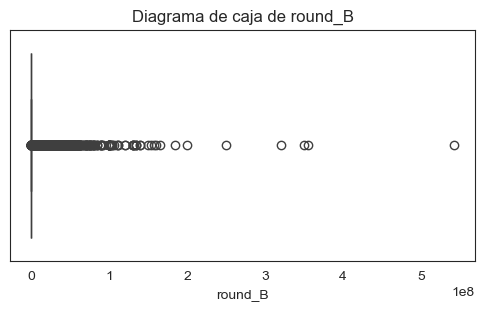

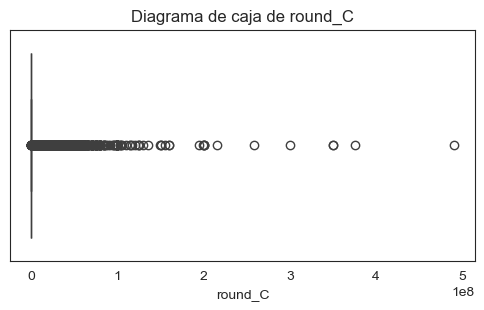

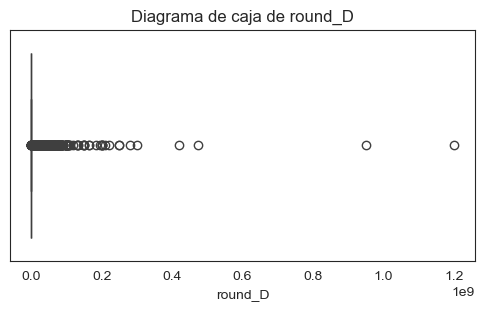

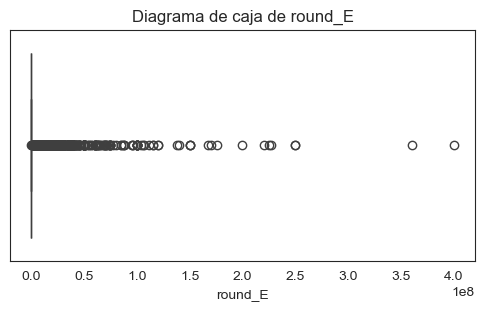

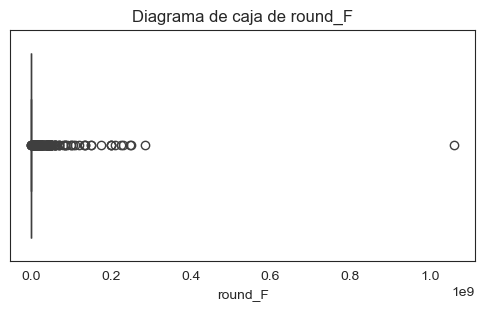

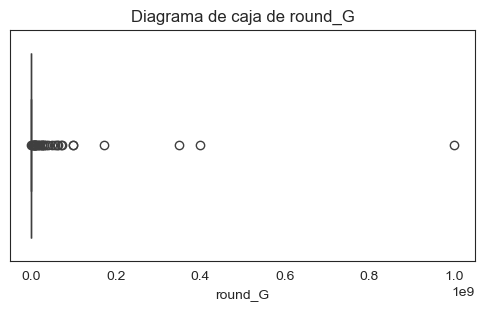

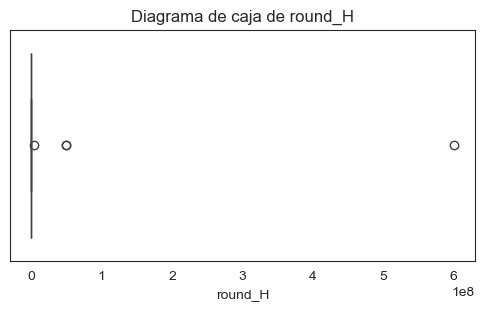

In [40]:
# Filtrar solo las columnas num√©ricas si es necesario
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

# Dibujar boxplots para cada variable num√©rica
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Diagrama de caja de {col}')
    plt.show()


### Observaciones a partir de los boxplots

Los **diagramas de caja** que generamos muestran una **asimetr√≠a considerable** en la distribuci√≥n de las variables de financiaci√≥n. En la mayor√≠a de los casos, los datos est√°n muy concentrados en valores bajos, mientras que hay una **cola larga** hacia la derecha, lo que sugiere la presencia de **outliers o valores extremos**.

Esta distribuci√≥n tan sesgada puede afectar negativamente al rendimiento de los modelos predictivos, ya que los algoritmos pueden verse influenciados por estos valores extremos.

Por eso, vamos a **revisar cada variable num√©rica por separado**, intentando entender qu√© est√° causando esa asimetr√≠a. En funci√≥n del an√°lisis, aplicaremos **transformaciones estad√≠sticas o t√©cnicas de normalizaci√≥n** que nos ayuden a reducir el sesgo.

El objetivo es que los datos est√©n en mejores condiciones para el modelado, lo que har√° que los resultados de los modelos sean m√°s **estables y fiables**.


### Buscamos variables relacionadas I

In [41]:
cutoffs = {
    'equity_crowdfunding': 3e6,       # Financiaci√≥n por crowdfunding de acciones ‚Üí 3 millones de d√≥lares
    'product_crowdfunding': 3e6,      # Financiaci√≥n por crowdfunding de productos ‚Üí 3 millones de d√≥lares
    'undisclosed': 20e6,              # Financiaci√≥n de origen no revelado ‚Üí 20 millones de d√≥lares
    'venture': 50e6,                  # Financiaci√≥n de capital riesgo ‚Üí 50 millones de d√≥lares
    'grant': 5e6,                     # Subvenciones ‚Üí 5 millones de d√≥lares
    'private_equity': 300e6,          # Capital privado ‚Üí 300 millones de d√≥lares
    'secondary_market': 100e6,        # Mercado secundario ‚Üí 100 millones de d√≥lares
    'convertible_note': 5e6,          # Notas convertibles ‚Üí 5 millones de d√≥lares
    'angel': 5e6,                     # Financiaci√≥n de inversores √°ngeles ‚Üí 5 millones de d√≥lares
    'seed': 10e6,                     # Ronda semilla ‚Üí 10 millones de d√≥lares
    'round_A': 20e6,                  # Serie A ‚Üí 20 millones de d√≥lares
    'round_B': 30e6,                  # Serie B ‚Üí 30 millones de d√≥lares
    'round_C': 40e6,                  # Serie C ‚Üí 40 millones de d√≥lares
    'round_D': 60e6,                  # Serie D ‚Üí 60 millones de d√≥lares
    'round_E': 80e6,                  # Serie E ‚Üí 80 millones de d√≥lares
    'round_F': 100e6,                 # Serie F ‚Üí 100 millones de d√≥lares
}
# Guardar el n√∫mero de filas original del conjunto de datos
original_data_count = df.shape[0]

# Aplicar los umbrales m√°ximos definidos para cada tipo de financiaci√≥n
# y filtrar las filas que superan dichos valores
for funding_type, cutoff in cutoffs.items():
    df = df[df[funding_type] <= cutoff]

# Mostrar informaci√≥n antes y despu√©s de eliminar los valores at√≠picos
print(f"Datos originales: {original_data_count} filas")
print(f"Forma del conjunto de datos tras eliminar los outliers de financiaci√≥n: {df.shape}")


Datos originales: 39752 filas
Forma del conjunto de datos tras eliminar los outliers de financiaci√≥n: (37330, 34)


### Justificaci√≥n de los umbrales aplicados

**Rondas iniciales (Seed, Angel, A, B, C):**  
Los l√≠mites establecidos para estas etapas tempranas reflejan las cantidades de financiaci√≥n que se observan con mayor frecuencia en startups en sus primeras fases. En este punto del desarrollo empresarial, las inversiones suelen ser m√°s moderadas, por lo que se han definido umbrales realistas que permiten descartar operaciones at√≠picamente altas y mantener el an√°lisis centrado en casos representativos.

**Rondas posteriores (D, E, F):**  
En etapas m√°s avanzadas, es habitual que las empresas necesiten mayores sumas para consolidar su crecimiento o expandirse a nuevos mercados. Por ello, los l√≠mites aplicados son m√°s altos y buscan capturar estos niveles de financiaci√≥n sin que algunas operaciones excepcionales influyan en exceso en el comportamiento general del conjunto de datos.

**Financiaci√≥n especializada (Private Equity, Crowdfunding, etc.):**  
Este tipo de financiaci√≥n presenta una gran variabilidad seg√∫n el sector o el contexto de inversi√≥n. Se han definido l√≠mites que permiten incluir una gran parte de los casos habituales, pero que al mismo tiempo filtran aquellas operaciones que se alejan significativamente de la norma y que podr√≠an distorsionar los resultados del an√°lisis.


In [42]:
from scipy import stats
# An√°lisis de valores at√≠picos (outliers) para la variable 'funding_rounds'

# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1_funding_rounds = df['funding_rounds'].quantile(0.25)
Q3_funding_rounds = df['funding_rounds'].quantile(0.75)
IQR_funding_rounds = Q3_funding_rounds - Q1_funding_rounds  # Rango intercuart√≠lico

# Definir outliers como aquellos que est√°n fuera de 1.5 * IQR por debajo de Q1 o por encima de Q3
outliers_IQR_funding_rounds = df[
    (df['funding_rounds'] < (Q1_funding_rounds - 1.5 * IQR_funding_rounds)) |
    (df['funding_rounds'] > (Q3_funding_rounds + 1.5 * IQR_funding_rounds))
]

# Calcular los Z-scores para detectar outliers extremos
z_scores_funding_rounds = np.abs(stats.zscore(df['funding_rounds']))
outliers_Z_funding_rounds = df[z_scores_funding_rounds > 3]

# Contar el n√∫mero de valores at√≠picos detectados por cada m√©todo
outliers_IQR_count_funding_rounds = outliers_IQR_funding_rounds.shape[0]
outliers_Z_count_funding_rounds = outliers_Z_funding_rounds.shape[0]

# Imprimir los resultados
print(f"N√∫mero de outliers detectados con el m√©todo IQR: {outliers_IQR_count_funding_rounds}")
print(f"N√∫mero de outliers detectados con el m√©todo Z-score: {outliers_Z_count_funding_rounds}")


N√∫mero de outliers detectados con el m√©todo IQR: 2925
N√∫mero de outliers detectados con el m√©todo Z-score: 630


C:\Users\marti\AppData\Local\Temp\ipykernel_20472\738668040.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funding_rounds_counts.index, y=funding_rounds_counts.values, palette='viridis')


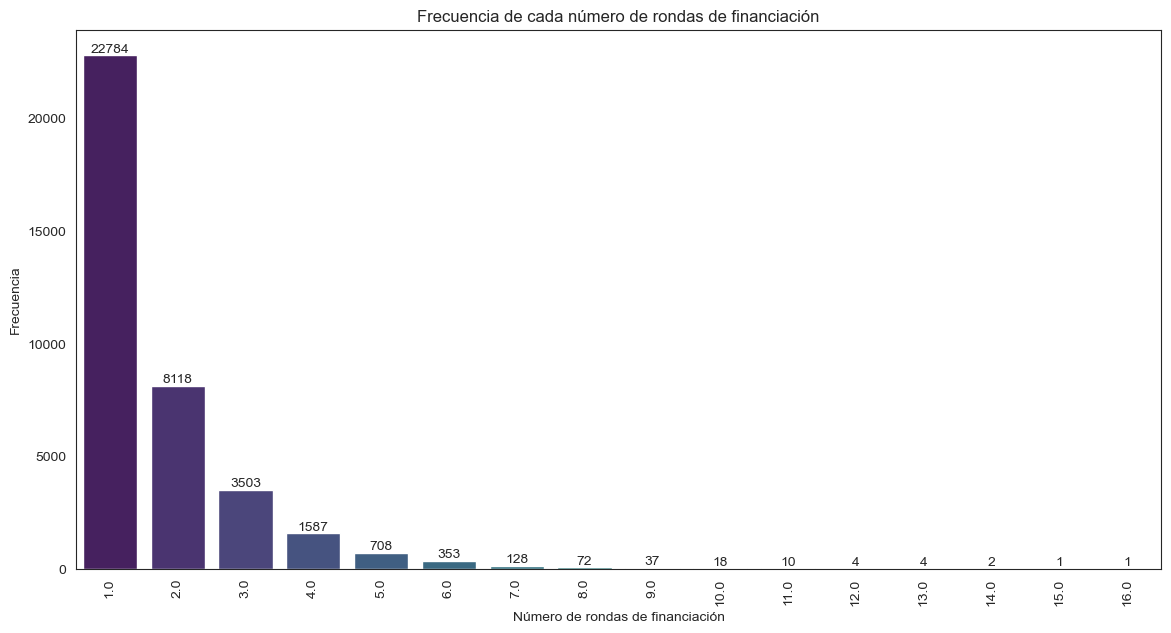

In [43]:
# Contar la frecuencia de cada n√∫mero de rondas de financiaci√≥n
funding_rounds_counts = df['funding_rounds'].value_counts().sort_index()

# Crear un gr√°fico de barras
plt.figure(figsize=(14, 7))
sns.barplot(x=funding_rounds_counts.index, y=funding_rounds_counts.values, palette='viridis')

# A√±adir anotaciones con los valores exactos
for i, count in enumerate(funding_rounds_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Frecuencia de cada n√∫mero de rondas de financiaci√≥n')
plt.xlabel('N√∫mero de rondas de financiaci√≥n')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar etiquetas si se solapan
plt.show()


### Validaci√≥n

In [44]:
# === Aplicar eliminaci√≥n de outliers por IQR
df_iqr = df.copy()
q1 = df_iqr['funding_rounds'].quantile(0.25)
q3 = df_iqr['funding_rounds'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df_iqr = df_iqr[(df_iqr['funding_rounds'] >= lower) & (df_iqr['funding_rounds'] <= upper)]

# === Aplicar eliminaci√≥n de outliers por Z-score
df_z = df.copy()
z_scores = np.abs(stats.zscore(df_z['funding_rounds']))
df_z = df_z[z_scores <= 3]

# === Separar X e y
X_iqr = df_iqr.drop(columns='exito')
y_iqr = df_iqr['exito']
X_z = df_z.drop(columns='exito')
y_z = df_z['exito']

# === ColumnTransformer (sin funciones que eliminan filas)
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# === Pipelines
pipeline_iqr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline_z = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# === Split estratificado para cada conjunto
for intento in range(10):
    X_train_iqr, X_val_iqr, y_train_iqr, y_val_iqr = train_test_split(X_iqr, y_iqr, test_size=0.3, stratify=y_iqr, random_state=42+intento)
    if len(np.unique(y_train_iqr)) > 1: break

for intento in range(10):
    X_train_z, X_val_z, y_train_z, y_val_z = train_test_split(X_z, y_z, test_size=0.3, stratify=y_z, random_state=42+intento)
    if len(np.unique(y_train_z)) > 1: break

# === Evaluaci√≥n
print("üîç Evaluaci√≥n con IQR:")
resultado_iqr = evaluar_pipeline(X_train_iqr, y_train_iqr, X_val_iqr, y_val_iqr, pipeline_iqr)

print("\nüîç Evaluaci√≥n con Z-score:")
resultado_z = evaluar_pipeline(X_train_z, y_train_z, X_val_z, y_val_z, pipeline_z)


üîç Evaluaci√≥n con IQR:
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1876
AUC-PR:      0.1687

üîç Evaluaci√≥n con Z-score:
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1846
AUC-PR:      0.1496


### Criterio para limitar el n√∫mero de rondas de financiaci√≥n
Aunque el uso del IQR nos permitir√≠a eliminar valores extremos, este m√©todo podr√≠a descartar demasiados casos relevantes, especialmente aquellos con un n√∫mero razonable de rondas. Por eso, en lugar de aplicar un umbral estad√≠stico, optamos por eliminar √∫nicamente las startups que tienen m√°s de 10 rondas de financiaci√≥n.

Superar esta cifra suele ser poco habitual en el √°mbito del venture capital y puede reflejar dificultades prolongadas para alcanzar la rentabilidad o una necesidad extraordinaria de capital. Limitar el n√∫mero de rondas a un m√°ximo de 10 nos permite mantener el enfoque en trayectorias de inversi√≥n m√°s comunes y realistas, lo que mejora tanto la representatividad del conjunto de datos como la capacidad predictiva del modelo.

In [45]:
print("Tama√±o del conjunto de datos antes de eliminar outliers en funding_rounds:", df.shape)
df = df[df['funding_rounds'] <= 10]
print("Tama√±o del conjunto de datos despu√©s de eliminar outliers en funding_rounds:", df.shape)

Tama√±o del conjunto de datos antes de eliminar outliers en funding_rounds: (37330, 34)
Tama√±o del conjunto de datos despu√©s de eliminar outliers en funding_rounds: (37308, 34)


### Buscamos variables relacionadas II

<Axes: xlabel='founded_year', ylabel='Count'>

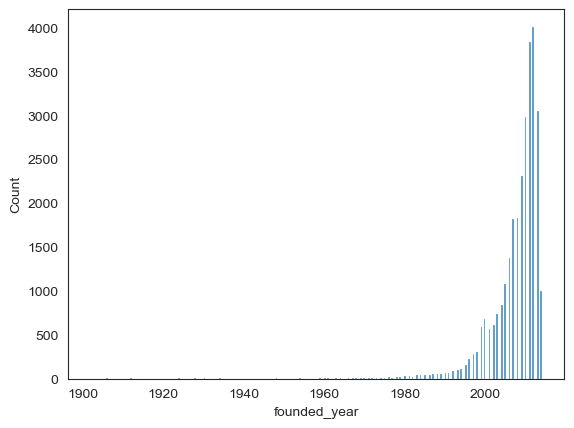

In [46]:
import seaborn as sns
sns.histplot(df['founded_year'].dropna(), kde=False)

In [47]:
print("Tama√±o del conjunto de datos antes de eliminar a√±os anteriores a 1990:", df.shape)

df = df[df['founded_year'].dt.year >= 1990]

print("Tama√±o del conjunto de datos despu√©s de eliminar a√±os anteriores a 1990:", df.shape)


Tama√±o del conjunto de datos antes de eliminar a√±os anteriores a 1990: (37308, 34)
Tama√±o del conjunto de datos despu√©s de eliminar a√±os anteriores a 1990: (28690, 34)


<Axes: xlabel='founded_year', ylabel='Count'>

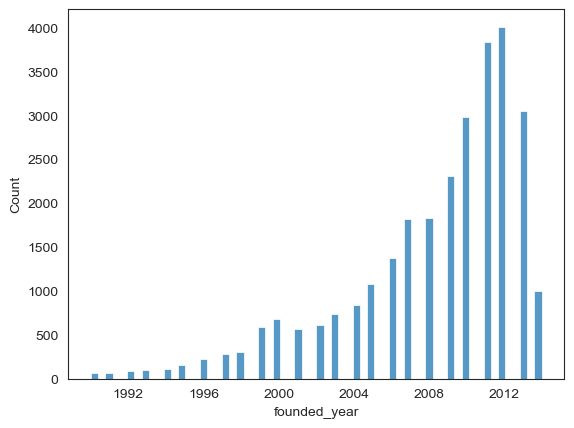

In [48]:
sns.histplot(df['founded_year'].dropna(), kde=False)

Al analizar datos de startups, la variable del a√±o de fundaci√≥n permite estimar su grado de madurez. Sin embargo, a√±os de fundaci√≥n excesivamente antiguos pueden distorsionar los an√°lisis y corresponder a entidades que no representan las din√°micas actuales del emprendimiento. Por ello, se emplean t√©cnicas estad√≠sticas como el rango intercuart√≠lico (IQR) y el Z-score para identificar y excluir estos casos at√≠picos. Esta depuraci√≥n garantiza que el conjunto de datos se centre en empresas m√°s representativas del panorama empresarial contempor√°neo, mejorando as√≠ la validez de los an√°lisis realizados.

In [49]:
def calcular_outliers_fecha(df, nombre_columna):
    # Convertir la fecha a n√∫mero ordinal
    df[nombre_columna + '_ordinal'] = df[nombre_columna].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Calcular Q1, Q3 y el rango intercuart√≠lico (IQR)
    Q1 = df[nombre_columna + '_ordinal'].quantile(0.25)
    Q3 = df[nombre_columna + '_ordinal'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los l√≠mites para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Contar outliers usando el m√©todo del IQR
    outliers_inferiores_IQR = df[df[nombre_columna + '_ordinal'] < limite_inferior].shape[0]
    outliers_superiores_IQR = df[df[nombre_columna + '_ordinal'] > limite_superior].shape[0]
    
    # Contar outliers usando el m√©todo de Z-score
    z_scores = np.abs(stats.zscore(df[nombre_columna + '_ordinal'].dropna()))
    outliers_Z = np.sum(z_scores > 3)

    print(f"N√∫mero de outliers inferiores para {nombre_columna} (m√©todo IQR): {outliers_inferiores_IQR}")
    print(f"N√∫mero de outliers superiores para {nombre_columna} (m√©todo IQR): {outliers_superiores_IQR}")
    print(f"N√∫mero de outliers para {nombre_columna} (m√©todo Z-score): {outliers_Z}")

# Aplicar la funci√≥n a cada columna de fecha
columnas_fecha = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
for columna in columnas_fecha:
    if columna in df.columns:
        calcular_outliers_fecha(df, columna)


N√∫mero de outliers inferiores para founded_at (m√©todo IQR): 1065
N√∫mero de outliers superiores para founded_at (m√©todo IQR): 0
N√∫mero de outliers para founded_at (m√©todo Z-score): 312
N√∫mero de outliers inferiores para founded_month (m√©todo IQR): 1065
N√∫mero de outliers superiores para founded_month (m√©todo IQR): 0
N√∫mero de outliers para founded_month (m√©todo Z-score): 312
N√∫mero de outliers inferiores para first_funding_at (m√©todo IQR): 390
N√∫mero de outliers superiores para first_funding_at (m√©todo IQR): 0
N√∫mero de outliers para first_funding_at (m√©todo Z-score): 258
N√∫mero de outliers inferiores para last_funding_at (m√©todo IQR): 871
N√∫mero de outliers superiores para last_funding_at (m√©todo IQR): 0
N√∫mero de outliers para last_funding_at (m√©todo Z-score): 204


### Validaci√≥n

In [50]:
def remove_datetime_outliers_by_z(df, datetime_col, threshold=3):
    # Convert to ordinal
    df[datetime_col + '_ordinal'] = df[datetime_col].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

    # Calculate z-scores
    z_scores = np.abs(stats.zscore(df[datetime_col + '_ordinal'].dropna()))
    outliers_mask = df[datetime_col + '_ordinal'].dropna().index[z_scores > threshold]
    
    print(f"{datetime_col}: Eliminados {len(outliers_mask)} outliers con Z-score")
    
    return df.drop(index=outliers_mask)

# Aplica a todas las columnas datetime
datetime_columns = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
df_z = df.copy()
for col in datetime_columns:
    if col in df_z.columns:
        df_z = remove_datetime_outliers_by_z(df_z, col)

# === Separar X e y
X_z = df_z.drop(columns='exito')
y_z = df_z['exito']

# === Definir columnas
num_cols = X_z.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_z.select_dtypes(include=['object']).columns.tolist()

# === ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# === Pipeline con SMOTE + RandomForest
pipeline_z = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# === Split estratificado (asegurando ambas clases)
for intento in range(10):
    X_train_z, X_val_z, y_train_z, y_val_z = train_test_split(X_z, y_z, test_size=0.3, stratify=y_z, random_state=42+intento)
    if len(np.unique(y_train_z)) > 1:
        break

# === Evaluaci√≥n
print("\nüîç Evaluaci√≥n tras eliminar outliers temporales con Z-score:")
resultado_z = evaluar_pipeline(X_train_z, y_train_z, X_val_z, y_val_z, pipeline_z)

founded_at: Eliminados 312 outliers con Z-score
founded_month: Eliminados 256 outliers con Z-score
first_funding_at: Eliminados 258 outliers con Z-score
last_funding_at: Eliminados 222 outliers con Z-score

üîç Evaluaci√≥n tras eliminar outliers temporales con Z-score:
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1504
AUC-PR:      0.2842


Despu√©s de haber eliminado previamente los valores at√≠picos en ``funding_year``, utilizamos los z-scores para eliminar outliers en las variables temporales, ya que este enfoque proporciona una base estad√≠stica s√≥lida que tiene en cuenta la distribuci√≥n de los datos y permite manejar de forma efectiva los valores extremos.

In [51]:
def eliminar_outliers_fecha(df, nombre_columna, umbral_z=3):
    # Convertimos la fecha a un valor num√©rico ordinal
    df[nombre_columna + '_ordinal'] = df[nombre_columna].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Calculamos los z-scores
    z_scores = np.abs(stats.zscore(df[nombre_columna + '_ordinal'].dropna()))
    
    # Identificamos los √≠ndices que superan el umbral de z-score
    indices_outliers = np.where(z_scores > umbral_z)[0]
    
    # Eliminamos las filas correspondientes
    df.drop(df.index[indices_outliers], inplace=True)
    
    # Mostramos cu√°ntas filas se eliminaron
    num_filas_eliminadas = len(indices_outliers)
    print(f"Filas eliminadas en '{nombre_columna}': {num_filas_eliminadas}")

# Mostramos el tama√±o del conjunto de datos antes de la eliminaci√≥n
print(f"Tama√±o del conjunto antes de eliminar outliers (global): {df.shape}")

# Aplicamos la funci√≥n a cada columna de tipo fecha
columnas_fecha = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
for columna in columnas_fecha:
    if columna in df.columns:
        eliminar_outliers_fecha(df, columna)

# Mostramos el tama√±o final del conjunto de datos
print(f"Tama√±o del conjunto despu√©s de eliminar outliers (global): {df.shape}")


Tama√±o del conjunto antes de eliminar outliers (global): (28690, 38)
Filas eliminadas en 'founded_at': 312
Filas eliminadas en 'founded_month': 256
Filas eliminadas en 'first_funding_at': 258
Filas eliminadas en 'last_funding_at': 194
Tama√±o del conjunto despu√©s de eliminar outliers (global): (27670, 38)


In [52]:
# Distribution of numerical columns after outlier analysis to check, if all still have values in them
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("Distribucion de variables num√©ricas:\n")
df[numerical_columns].describe().T

Distribucion de variables num√©ricas:



count          mean           std       min  \
funding_total_usd         27670.0  7.556290e+06  4.479430e+07      14.0   
exito                     27670.0  7.701482e-02  2.666198e-01       0.0   
funding_rounds            27670.0  1.799566e+00  1.219672e+00       1.0   
seed                      27670.0  3.039538e+05  7.433779e+05       0.0   
venture                   27670.0  4.780870e+06  9.003735e+06       0.0   
equity_crowdfunding       27670.0  4.379302e+03  6.824252e+04       0.0   
undisclosed               27670.0  4.062394e+04  5.745925e+05       0.0   
convertible_note          27670.0  1.243613e+04  1.578658e+05       0.0   
angel                     27670.0  7.110009e+04  3.386175e+05       0.0   
grant                     27670.0  1.395565e+04  1.838579e+05       0.0   
private_equity            27670.0  1.094595e+06  1.217049e+07       0.0   
secondary_market          27670.0  3.609895e+03  3.890524e+05       0.0   
product_crowdfunding      27670.0  3.180610e+03  6.674555e+04       0.0   
round_A                   27670.0  1.067323e+06  2.735950e+06       0.0   
round_B                   27670.0  1.130905e+06  3.752116e+06       0.0   
round_C                   27670.0  6.248899e+05  3.214592e+06       0.0   
round_D                   27670.0  2.261618e+05  2.071126e+06       0.0   
round_E                   27670.0  6.586520e+04  1.059114e+06       0.0   
round_F                   27670.0  1.629827e+04  5.499376e+05       0.0   
round_G                   27670.0  2.399711e+03  1.906693e+05       0.0   
round_H                   27670.0  1.662450e+02  2.765370e+04       0.0   
founded_at_ordinal        27670.0  7.333451e+05  1.548804e+03  728353.0   
founded_month_ordinal     27670.0  7.333424e+05  1.547474e+03  728353.0   
first_funding_at_ordinal  27668.0  7.342876e+05  9.390465e+02  729390.0   
last_funding_at_ordinal   27670.0  7.346364e+05  8.274485e+02  732006.0   

                                25%        50%         75%           max  
funding_total_usd         270007.75  1500000.0  6639277.75  5.700000e+09  
exito                          0.00        0.0        0.00  1.000000e+00  
funding_rounds                 1.00        1.0        2.00  1.000000e+01  
seed                           0.00        0.0   175000.00  1.000000e+07  
venture                        0.00   179999.5  5144800.00  5.000000e+07  
equity_crowdfunding            0.00        0.0        0.00  3.000000e+06  
undisclosed                    0.00        0.0        0.00  1.874856e+07  
convertible_note               0.00        0.0        0.00  5.000000e+06  
angel                          0.00        0.0        0.00  5.000000e+06  
grant                          0.00        0.0        0.00  5.000000e+06  
private_equity                 0.00        0.0        0.00  3.000000e+08  
secondary_market               0.00        0.0        0.00  6.000000e+07  
product_crowdfunding           0.00        0.0        0.00  3.000000e+06  
round_A                        0.00        0.0        0.00  2.000000e+07  
round_B                        0.00        0.0        0.00  3.000000e+07  
round_C                        0.00        0.0        0.00  4.000000e+07  
round_D                        0.00        0.0        0.00  5.000000e+07  
round_E                        0.00        0.0        0.00  4.000000e+07  
round_F                        0.00        0.0        0.00  4.160000e+07  
round_G                        0.00        0.0        0.00  2.600000e+07  
round_H                        0.00        0.0        0.00  4.600000e+06  
founded_at_ordinal        732646.00   733773.0   734503.00  7.355800e+05  
founded_month_ordinal     732646.00   733773.0   734503.00  7.355680e+05  
first_funding_at_ordinal  733723.00   734503.0   735060.00  7.355910e+05  
last_funding_at_ordinal   734167.25   734928.0   735282.00  7.355910e+05

In [53]:
# Como la columna round_H ahora est√° vac√≠a (lo cual tiene sentido, ya que casi nunca ocurre tambi√©n en la realidad), la eliminaremos del conjunto de datos
df.drop('round_H', axis=1, inplace=True)

## 7. Transformaci√≥n del tipo de variable

En primer lugar, antes de estandarizar los datos, nos tenemos que asegurar de que est√°n en su tipo correcto. Es por ello, por lo que primero hay que:
1. Transformar los tipos de datos que consideremos.
2. Imputar los valores perdidos

In [54]:
# Sobreescribe la original con el a√±o entero
df['founded_year'] = df['founded_year'].dt.year

# Ahora aplica pd.cut en l√≠nea sobre esa columna
df['founded_year'] = pd.cut(
    df['founded_year'],
    bins=[1900, 1925, 1950, 1975, 2000, 2015],
    labels=['1900‚Äì25','25‚Äì50','50‚Äì75','75‚Äì00','00‚Äì14'],
    include_lowest=True
)
df['founded_year'] = df['founded_year'].cat.codes.replace(-1, np.nan)


Creacion de variables (Feature Engineering -> La parte de EDA, esta realizada ya en el primer hito)

Agrupamos los pa√≠ses por continentes y los mercados por industrias como t√©cnica de agregaci√≥n de caracter√≠sticas, lo que reduce la dimensionalidad del dataset y estabiliza la variabilidad. Esto simplifica los modelos y mejora su capacidad de generalizaci√≥n. Para las industrias, seguimos la clasificaci√≥n oficial de Crunchbase:https://support.crunchbase.com/hc/en-us/articles/360043146954-What-Industries-are-included-in-Crunchbase-


In [55]:
admin_services = str('Employer Benefits Programs, Human Resource Automation, Corporate IT, Distribution, Service Providers, Archiving Service, Call Center, Collection Agency, College Recruiting, Courier Service, Debt Collections, Delivery, Document Preparation, Employee Benefits, Extermination Service, Facilities Support Services, Housekeeping Service, Human Resources, Knowledge Management, Office Administration, Packaging Services, Physical Security, Project Management, Staffing Agency, Trade Shows, Virtual Workforce').split(', ')
advertising = str('Creative Industries, Promotional, Advertising Ad Exchange, Ad Network, Ad Retargeting, Ad Server, Ad Targeting, Advertising, Advertising Platforms, Affiliate Marketing, Local Advertising, Mobile Advertising, Outdoor Advertising, SEM, Social Media Advertising, Video Advertising').split(', ')
agriculture = str('Agriculture, AgTech, Animal Feed, Aquaculture, Equestrian, Farming, Forestry, Horticulture, Hydroponics, Livestock').split(', ')
app = str('Application Performance Monitoring, App Stores, Application Platforms, Enterprise Application, App Discovery, Apps, Consumer Applications, Enterprise Applications, Mobile Apps, Reading Apps, Web Apps').split(', ')
artificial_intelli = str('Artificial Intelligence, Intelligent Systems, Machine Learning, Natural Language Processing, Predictive Analytics').split(', ')
biotechnology = str('Synthetic Biology, Bio-Pharm, Bioinformatics, Biometrics, Biopharma, Biotechnology, Genetics, Life Science, Neuroscience, Quantified Self').split(', ')
clothing = str('Fashion, Laundry and Dry-cleaning, Lingerie, Shoes').split(', ')
shopping = str('Consumer Behavior, Customer Support Tools, Discounts, Reviews and Recommendations, Auctions, Classifieds, Collectibles, Consumer Reviews, Coupons, E-Commerce, E-Commerce Platforms, Flash Sale, Gift, Gift Card, Gift Exchange, Gift Registry, Group Buying, Local Shopping, Made to Order, Marketplace, Online Auctions, Personalization, Point of Sale, Price Comparison, Rental, Retail, Retail Technology, Shopping, Shopping Mall, Social Shopping, Sporting Goods, Vending and Concessions, Virtual Goods, Wholesale').split(', ')
community = str("Self Development, Sex, Forums, Match-Making, Babies, Identity, Women, Kids, Entrepreneur, Networking, Adult, Baby, Cannabis, Children, Communities, Dating, Elderly, Family, Funerals, Humanitarian, Leisure, LGBT, Lifestyle, Men's, Online Forums, Parenting, Pet, Private Social Networking, Professional Networking, Q&A, Religion, Retirement, Sex Industry, Sex Tech, Social, Social Entrepreneurship, Teenagers, Virtual World, Wedding, Women's, Young Adults").split(', ')
electronics  = str('Mac, iPod Touch, Tablets, iPad, iPhone, Computer, Consumer Electronics, Drones, Electronics, Google Glass, Mobile Devices, Nintendo, Playstation, Roku, Smart Home, Wearables, Windows Phone, Xbox').split(', ')
consumer_goods= str('Commodities, Sunglasses, Groceries, Batteries, Cars, Beauty, Comics, Consumer Goods, Cosmetics, DIY, Drones, Eyewear, Fast-Moving Consumer Goods, Flowers, Furniture, Green Consumer Goods, Handmade, Jewelry, Lingerie, Shoes, Tobacco, Toys').split(', ')
content = str('E-Books, MicroBlogging, Opinions, Blogging Platforms, Content Delivery Network, Content Discovery, Content Syndication, Creative Agency, DRM, EBooks, Journalism, News, Photo Editing, Photo Sharing, Photography, Printing, Publishing, Social Bookmarking, Video Editing, Video Streaming').split(', ')
data = str('Optimization, A/B Testing, Analytics, Application Performance Management, Artificial Intelligence, Big Data, Bioinformatics, Biometrics, Business Intelligence, Consumer Research, Data Integration, Data Mining, Data Visualization, Database, Facial Recognition, Geospatial, Image Recognition, Intelligent Systems, Location Based Services, Machine Learning, Market Research, Natural Language Processing, Predictive Analytics, Product Research, Quantified Self, Speech Recognition, Test and Measurement, Text Analytics, Usability Testing').split(', ')
design = str('Visualization, Graphics, Design, Designers, CAD, Consumer Research, Data Visualization, Fashion, Graphic Design, Human Computer Interaction, Industrial Design, Interior Design, Market Research, Mechanical Design, Product Design, Product Research, Usability Testing, UX Design, Web Design').split(', ')
education = str('Universities, College Campuses, University Students, High Schools, All Students, Colleges, Alumni, Charter Schools, College Recruiting, Continuing Education, Corporate Training, E-Learning, EdTech, Education, Edutainment, Higher Education, Language Learning, MOOC, Music Education, Personal Development, Primary Education, Secondary Education, Skill Assessment, STEM Education, Textbook, Training, Tutoring, Vocational Education').split(', ')
energy = str('Gas, Natural Gas Uses, Oil, Oil & Gas, Battery, Biofuel, Biomass Energy, Clean Energy, Electrical Distribution, Energy, Energy Efficiency, Energy Management, Energy Storage, Fossil Fuels, Fuel, Fuel Cell, Oil and Gas, Power Grid, Renewable Energy, Solar, Wind Energy').split(', ')
events = str('Concerts, Event Management, Event Promotion, Events, Nightclubs, Nightlife, Reservations, Ticketing, Wedding').split(', ')
financial = str('Debt Collecting, P2P Money Transfer, Investment Management, Trading, Accounting, Angel Investment, Asset Management, Auto Insurance, Banking, Bitcoin, Commercial Insurance, Commercial Lending, Consumer Lending, Credit, Credit Bureau, Credit Cards, Crowdfunding, Cryptocurrency, Debit Cards, Debt Collections, Finance, Financial Exchanges, Financial Services, FinTech, Fraud Detection, Funding Platform, Gift Card, Health Insurance, Hedge Funds, Impact Investing, Incubators, Insurance, InsurTech, Leasing, Lending, Life Insurance, Micro Lending, Mobile Payments, Payments, Personal Finance, Prediction Markets, Property Insurance, Real Estate Investment, Stock Exchanges, Trading Platform, Transaction Processing, Venture Capital, Virtual Currency, Wealth Management').split(', ')
food = str('Specialty Foods, Bakery, Brewing, Cannabis, Catering, Coffee, Confectionery, Cooking, Craft Beer, Dietary Supplements, Distillery, Farmers Market, Food and Beverage, Food Delivery, Food Processing, Food Trucks, Fruit, Grocery, Nutrition, Organic Food, Recipes, Restaurants, Seafood, Snack Food, Tea, Tobacco, Wine And Spirits, Winery').split(', ')
gaming = str('Game, Games, Casual Games, Console Games, Contests, Fantasy Sports, Gambling, Gamification, Gaming, MMO Games, Online Games, PC Games, Serious Games, Video Games').split(', ')
government = str('Polling, Governance, CivicTech, Government, GovTech, Law Enforcement, Military, National Security, Politics, Public Safety, Social Assistance').split(', ')
hardware= str('Cable, 3D, 3D Technology, Application Specific Integrated Circuit (ASIC), Augmented Reality, Cloud Infrastructure, Communication Hardware, Communications Infrastructure, Computer, Computer Vision, Consumer Electronics, Data Center, Data Center Automation, Data Storage, Drone Management, Drones, DSP, Electronic Design Automation (EDA), Electronics, Embedded Systems, Field-Programmable Gate Array (FPGA), Flash Storage, Google Glass, GPS, GPU, Hardware, Industrial Design, Laser, Lighting, Mechanical Design, Mobile Devices, Network Hardware, NFC, Nintendo, Optical Communication, Playstation, Private Cloud, Retail Technology, RFID, RISC, Robotics, Roku, Satellite Communication, Semiconductor, Sensor, Sex Tech, Telecommunications, Video Conferencing, Virtual Reality, Virtualization, Wearables, Windows Phone, Wireless, Xbox').split(', ')
health_care = str('Senior Health, Physicians, Electronic Health Records, Doctors, Healthcare Services, Diagnostics, Alternative Medicine, Assisted Living, Assistive Technology, Biopharma, Cannabis, Child Care, Clinical Trials, Cosmetic Surgery, Dental, Diabetes, Dietary Supplements, Elder Care, Electronic Health Record (EHR), Emergency Medicine, Employee Benefits, Fertility, First Aid, Funerals, Genetics, Health Care, Health Diagnostics, Home Health Care, Hospital, Medical, Medical Device, mHealth, Nursing and Residential Care, Nutraceutical, Nutrition, Outpatient Care, Personal Health, Pharmaceutical, Psychology, Rehabilitation, Therapeutics, Veterinary, Wellness').split(', ')
it = str('Distributors, Algorithms, ICT, M2M, Technology, Business Information Systems, CivicTech, Cloud Data Services, Cloud Management, Cloud Security, CMS, Contact Management, CRM, Cyber Security, Data Center, Data Center Automation, Data Integration, Data Mining, Data Visualization, Document Management, E-Signature, Email, GovTech, Identity Management, Information and Communications Technology (ICT), Information Services, Information Technology, Intrusion Detection, IT Infrastructure, IT Management, Management Information Systems, Messaging, Military, Network Security, Penetration Testing, Private Cloud, Reputation, Sales Automation, Scheduling, Social CRM, Spam Filtering, Technical Support, Unified Communications, Video Chat, Video Conferencing, Virtualization, VoIP').split(', ')
internet = str('Online Identity, Cyber, Portals, Web Presence Management, Domains, Tracking, Web Tools, Curated Web, Search, Cloud Computing, Cloud Data Services, Cloud Infrastructure, Cloud Management, Cloud Storage, Darknet, Domain Registrar, E-Commerce Platforms, Ediscovery, Email, Internet, Internet of Things, ISP, Location Based Services, Messaging, Music Streaming, Online Forums, Online Portals, Private Cloud, Product Search, Search Engine, SEM, Semantic Search, Semantic Web, SEO, SMS, Social Media, Social Media Management, Social Network, Unified Communications, Vertical Search, Video Chat, Video Conferencing, Visual Search, VoIP, Web Browsers, Web Hosting').split(', ')
invest = str('Angel Investment, Banking, Commercial Lending, Consumer Lending, Credit, Credit Cards, Financial Exchanges, Funding Platform, Hedge Funds, Impact Investing, Incubators, Micro Lending, Stock Exchanges, Trading Platform, Venture Capital').split(', ')
manufacturing = str('Innovation Engineering, Civil Engineers, Heavy Industry, Engineering Firms, Systems, 3D Printing, Advanced Materials, Foundries, Industrial, Industrial Automation, Industrial Engineering, Industrial Manufacturing, Machinery Manufacturing, Manufacturing, Paper Manufacturing, Plastics and Rubber Manufacturing, Textiles, Wood Processing').split(', ')
media = str('Writers, Creative, Television, Entertainment, Media, Advice, Animation, Art, Audio, Audiobooks, Blogging Platforms, Broadcasting, Celebrity, Concerts, Content, Content Creators, Content Discovery, Content Syndication, Creative Agency, Digital Entertainment, Digital Media, DRM, EBooks, Edutainment, Event Management, Event Promotion, Events, Film, Film Distribution, Film Production, Guides, In-Flight Entertainment, Independent Music, Internet Radio, Journalism, Media and Entertainment, Motion Capture, Music, Music Education, Music Label, Music Streaming, Music Venues, Musical Instruments, News, Nightclubs, Nightlife, Performing Arts, Photo Editing, Photo Sharing, Photography, Podcast, Printing, Publishing, Reservations, Social Media, Social News, Theatre, Ticketing, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming, Virtual World').split(', ')
message = str('Unifed Communications, Chat, Email, Meeting Software, Messaging, SMS, Unified Communications, Video Chat, Video Conferencing, VoIP, Wired Telecommunications').split(', ')
mobile = str('Android, Google Glass, iOS, mHealth, Mobile, Mobile Apps, Mobile Devices, Mobile Payments, Windows Phone, Wireless').split(', ')
music = str('Audio, Audiobooks, Independent Music, Internet Radio, Music, Music Education, Music Label, Music Streaming, Musical Instruments, Podcast').split(', ')
resource = str('Biofuel, Biomass Energy, Fossil Fuels, Mineral, Mining, Mining Technology, Natural Resources, Oil and Gas, Precious Metals, Solar, Timber, Water, Wind Energy').split(', ')
navigation = str('Maps, Geospatial, GPS, Indoor Positioning, Location Based Services, Mapping Services, Navigation').split(', ')
other = str('Mass Customization, Monetization, Testing, Subscription Businesses, Mobility, Incentives, Peer-to-Peer, Nonprofits, Alumni, Association, B2B, B2C, Blockchain, Charity, Collaboration, Collaborative Consumption, Commercial, Consumer, Crowdsourcing, Customer Service, Desktop Apps, Emerging Markets, Enterprise, Ethereum, Franchise, Freemium, Generation Y, Generation Z, Homeless Shelter, Infrastructure, Knowledge Management, LGBT Millennials, Non Profit, Peer to Peer, Professional Services, Project Management, Real Time, Retirement, Service Industry, Sharing Economy, Small and Medium Businesses, Social Bookmarking, Social Impact, Subscription Service, Technical Support, Underserved Children, Universities').split(', ')
payment = str('Billing, Bitcoin, Credit Cards, Cryptocurrency, Debit Cards, Fraud Detection, Mobile Payments, Payments, Transaction Processing, Virtual Currency').split(', ')
platforms = str('Development Platforms, Android, Facebook, Google, Google Glass, iOS, Linux, macOS, Nintendo, Operating Systems, Playstation, Roku, Tizen, Twitter, WebOS, Windows, Windows Phone, Xbox').split(', ')
privacy = str('Digital Rights Management, Personal Data, Cloud Security, Corrections Facilities, Cyber Security, DRM, E-Signature, Fraud Detection, Homeland Security, Identity Management, Intrusion Detection, Law Enforcement, Network Security, Penetration Testing, Physical Security, Privacy, Security').split(', ')
services = str('Funeral Industry, English-Speaking, Spas, Plumbers, Service Industries, Staffing Firms, Translation, Career Management, Business Services, Services, Accounting, Business Development, Career Planning, Compliance, Consulting, Customer Service, Employment, Environmental Consulting, Field Support, Freelance, Intellectual Property, Innovation Management, Legal, Legal Tech, Management Consulting, Outsourcing, Professional Networking, Quality Assurance, Recruiting, Risk Management, Social Recruiting, Translation Service').split(', ')
realestate= str('Office Space, Self Storage, Brokers, Storage, Home Owners, Self Storage , Realtors, Home & Garden, Utilities, Home Automation, Architecture, Building Maintenance, Building Material, Commercial Real Estate, Construction, Coworking, Facility Management, Fast-Moving Consumer Goods, Green Building, Home and Garden, Home Decor, Home Improvement, Home Renovation, Home Services, Interior Design, Janitorial Service, Landscaping, Property Development, Property Management, Real Estate, Real Estate Investment, Rental Property, Residential, Self-Storage, Smart Building, Smart Cities, Smart Home, Timeshare, Vacation Rental').split(', ')
sales = str('Advertising, Affiliate Marketing, App Discovery, App Marketing, Brand Marketing, Cause Marketing, Content Marketing, CRM, Digital Marketing, Digital Signage, Direct Marketing, Direct Sales, Email Marketing, Lead Generation, Lead Management, Local, Local Advertising, Local Business, Loyalty Programs, Marketing, Marketing Automation, Mobile Advertising, Multi-level Marketing, Outdoor Advertising, Personal Branding, Public Relations, Sales, Sales Automation, SEM, SEO, Social CRM, Social Media Advertising, Social Media Management, Social Media Marketing, Sponsorship, Video Advertising').split(', ')
science = str('Face Recognition, New Technologies, Advanced Materials, Aerospace, Artificial Intelligence, Bioinformatics, Biometrics, Biopharma, Biotechnology, Chemical, Chemical Engineering, Civil Engineering, Embedded Systems, Environmental Engineering, Human Computer Interaction, Industrial Automation, Industrial Engineering, Intelligent Systems, Laser, Life Science, Marine Technology, Mechanical Engineering, Nanotechnology, Neuroscience, Nuclear, Quantum Computing, Robotics, Semiconductor, Software Engineering, STEM Education').split(', ')
software = str('Business Productivity, 3D Technology, Android, App Discovery, Application Performance Management, Apps, Artificial Intelligence, Augmented Reality, Billing, Bitcoin, Browser Extensions, CAD, Cloud Computing, Cloud Management, CMS, Computer Vision, Consumer Applications, Consumer Software, Contact Management, CRM, Cryptocurrency, Data Center Automation, Data Integration, Data Storage, Data Visualization, Database, Developer APIs, Developer Platform, Developer Tools, Document Management, Drone Management, E-Learning, EdTech, Electronic Design Automation (EDA), Embedded Software, Embedded Systems, Enterprise Applications, Enterprise Resource Planning (ERP), Enterprise Software, Facial Recognition, File Sharing, IaaS, Image Recognition, iOS, Linux, Machine Learning, macOS, Marketing Automation, Meeting Software, Mobile Apps, Mobile Payments, MOOC, Natural Language Processing, Open Source, Operating Systems, PaaS, Predictive Analytics, Presentation Software, Presentations, Private Cloud, Productivity Tools, QR Codes, Reading Apps, Retail Technology, Robotics, SaaS, Sales Automation, Scheduling, Sex Tech, Simulation, SNS, Social CRM, Software, Software Engineering, Speech Recognition, Task Management, Text Analytics, Transaction Processing, Video Conferencing, Virtual Assistant, Virtual Currency, Virtual Desktop, Virtual Goods, Virtual Reality, Virtual World, Virtualization, Web Apps, Web Browsers, Web Development').split(', ')
sports = str('American Football, Baseball, Basketball, Boating, Cricket, Cycling, Diving, eSports, Fantasy Sports, Fitness, Golf, Hockey, Hunting, Outdoors, Racing, Recreation, Rugby, Sailing, Skiing, Soccer, Sporting Goods, Sports, Surfing, Swimming, Table Tennis, Tennis, Ultimate Frisbee, Volley Ball').split(', ')
sustainability = str('Green, Wind, Biomass Power Generation, Renewable Tech, Environmental Innovation, Renewable Energies, Clean Technology, Biofuel, Biomass Energy, Clean Energy, CleanTech, Energy Efficiency, Environmental Engineering, Green Building, Green Consumer Goods, GreenTech, Natural Resources, Organic, Pollution Control, Recycling, Renewable Energy, Solar, Sustainability, Waste Management, Water Purification, Wind Energy').split(', ')
transportation = str('Taxis, Air Transportation, Automotive, Autonomous Vehicles, Car Sharing, Courier Service, Delivery Service, Electric Vehicle, Ferry Service, Fleet Management, Food Delivery, Freight Service, Last Mile Transportation, Limousine Service, Logistics, Marine Transportation, Parking, Ports and Harbors, Procurement, Public Transportation, Railroad, Recreational Vehicles, Ride Sharing, Same Day Delivery, Shipping, Shipping Broker, Space Travel, Supply Chain Management, Taxi Service, Transportation, Warehousing, Water Transportation').split(', ')
travel = str('Adventure Travel, Amusement Park and Arcade, Business Travel, Casino, Hospitality, Hotel, Museums and Historical Sites, Parks, Resorts, Timeshare, Tour Operator, Tourism, Travel, Travel Accommodations, Travel Agency, Vacation Rental').split(', ')
video = str('Animation, Broadcasting, Film, Film Distribution, Film Production, Motion Capture, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming').split(', ')

In [56]:
#utilizamos un diccionario para asignar a cada uno su respectivo grupo
industry_keywords = {
    "Administrative Services": admin_services,
    "Software": software,
    "Advertising": advertising,
    "Agriculture": agriculture,
    "App" : app,
    "Artificial Intelligence": artificial_intelli,
    "Biotechnology": biotechnology,
    "Clothing" : clothing,
    "Shopping" : shopping,
    "Community" : community,
    "Electronics" : electronics,
    "Consumer Goods": consumer_goods,
    "Content": content,
    "Data" : data,
    "Design" : design,
    "Education" : education,
    "Energy" : energy,
    "Events" : events,
    "Financial" : financial,
    "Food" : food,
    "Gaming" : gaming,
    "Goverment" : government,
    "Hardware" : hardware,
    "Health Care" : health_care,
    "Video": video,
    "Travel": travel,
    "Transportation": transportation,
    "Sustainability": sustainability,
    "Sports": sports,
    "Software": software,
    "Science": science,
    "Sales": sales,
    "Real Estate": realestate,
    "Services": services,
    "Privacy": privacy,
    "Platforms": platforms,
    "Payment": payment,
    "Other": other,
    "Navigation": navigation,
    "Resource": resource,
    "Music": music,
    "Mobile": mobile,
    "Message" : message,
    "Media": media,
    "Manufacturing": manufacturing,
    "Invest": invest,
    "Internet": internet,
    "IT": it
}

In [57]:
import re
def get_industry_group(market_string):
    if not isinstance(market_string, str):  # Comprobamos que es string
        return "Unknown" 
    for industry, keywords in industry_keywords.items():
        # Expresion regular para buscar palabras clave
        pattern = '|'.join(map(re.escape, keywords))
        if re.search(pattern, market_string, flags=re.IGNORECASE):
            return industry
    return "Other" 

df['industry_group'] = df['market'].apply(get_industry_group)

In [58]:
print("Number of unique industries:", df['industry_group'].nunique())
df.groupby('industry_group').size().sort_values(ascending = False).reset_index()

Number of unique industries: 46


industry_group     0
0                  Software  5666
1             Biotechnology  1864
2                  Internet  1739
3               Health Care  1642
4                  Shopping  1581
5                    Mobile  1313
6                 Community  1283
7               Advertising  1056
8                   Unknown   926
9                    Gaming   827
10                Financial   814
11                     Data   696
12                    Other   618
13                Education   613
14                 Services   597
15           Sustainability   574
16                  Content   569
17                    Media   520
18                    Sales   494
19                  Privacy   398
20              Real Estate   318
21            Manufacturing   315
22                   Travel   290
23                  Message   283
24           Transportation   268
25              Electronics   232
26                 Hardware   230
27                       IT   219
28                 Clothing   215
29                    Video   190
30                    Music   185
31                   Sports   178
32                   Design   148
33                   Events   120
34                     Food   115
35                Platforms   104
36  Administrative Services   103
37           Consumer Goods    96
38                   Energy    88
39                  Science    64
40                Goverment    37
41               Navigation    29
42                      App    23
43              Agriculture    19
44                 Resource     8
45  Artificial Intelligence     3

Mapeo de los paises - Continentes (no lo he hecho hace falta otro dataset)

Creacion de categor√≠as para distintos fundings.. -> transformaci√≥n de continuas en categoricas (binning).</br>
El binning sirve para convertir variables continuas en categor√≠as, lo que hace que el modelo sea m√°s f√°cil de entender y puede ayudar a que funcione mejor. Tambi√©n reduce el impacto de peque√±as variaciones o errores en los datos, algo √∫til cuando hay mucho ruido en el conjunto.

In [59]:
df = df.drop(['market'], axis=1) #ya tenemos industry_group, no necesitamos market

In [60]:
def calculate_funding_total(df):
    df["funding_total_usd"] = df["funding_total_usd"].fillna(0)
       
    columns_to_sum = ['funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 
                      'convertible_note', 'angel', 'grant', 'private_equity', 'secondary_market', 
                      'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 
                      'round_E', 'round_F', 'round_G']
    df["funding_total_usd"] = df[columns_to_sum].sum(axis=1)

calculate_funding_total(df)

In [61]:
df[['funding_rounds', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'angel', 'grant',
       'private_equity',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G',
      'funding_total_usd']].describe().T

count          mean           std  min        25%  \
funding_rounds        27670.0  1.799566e+00  1.219672e+00  1.0       1.00   
seed                  27670.0  3.039538e+05  7.433779e+05  0.0       0.00   
venture               27670.0  4.780870e+06  9.003735e+06  0.0       0.00   
equity_crowdfunding   27670.0  4.379302e+03  6.824252e+04  0.0       0.00   
undisclosed           27670.0  4.062394e+04  5.745925e+05  0.0       0.00   
convertible_note      27670.0  1.243613e+04  1.578658e+05  0.0       0.00   
angel                 27670.0  7.110009e+04  3.386175e+05  0.0       0.00   
grant                 27670.0  1.395565e+04  1.838579e+05  0.0       0.00   
private_equity        27670.0  1.094595e+06  1.217049e+07  0.0       0.00   
secondary_market      27670.0  3.609895e+03  3.890524e+05  0.0       0.00   
product_crowdfunding  27670.0  3.180610e+03  6.674555e+04  0.0       0.00   
round_A               27670.0  1.067323e+06  2.735950e+06  0.0       0.00   
round_B               27670.0  1.130905e+06  3.752116e+06  0.0       0.00   
round_C               27670.0  6.248899e+05  3.214592e+06  0.0       0.00   
round_D               27670.0  2.261618e+05  2.071126e+06  0.0       0.00   
round_E               27670.0  6.586520e+04  1.059114e+06  0.0       0.00   
round_F               27670.0  1.629827e+04  5.499376e+05  0.0       0.00   
round_G               27670.0  2.399711e+03  1.906693e+05  0.0       0.00   
funding_total_usd     27670.0  9.462550e+06  1.986897e+07  1.0  225041.25   

                            50%         75%          max  
funding_rounds              1.0        2.00         10.0  
seed                        0.0   175000.00   10000000.0  
venture                179999.5  5144800.00   50000000.0  
equity_crowdfunding         0.0        0.00    3000000.0  
undisclosed                 0.0        0.00   18748565.0  
convertible_note            0.0        0.00    5000000.0  
angel                       0.0        0.00    5000000.0  
grant                       0.0        0.00    5000000.0  
private_equity              0.0        0.00  300000000.0  
secondary_market            0.0        0.00   60000000.0  
product_crowdfunding        0.0        0.00    3000000.0  
round_A                     0.0        0.00   20000000.0  
round_B                     0.0        0.00   30000000.0  
round_C                     0.0        0.00   40000000.0  
round_D                     0.0        0.00   50000000.0  
round_E                     0.0        0.00   40000000.0  
round_F                     0.0        0.00   41600000.0  
round_G                     0.0        0.00   26000000.0  
funding_total_usd     1500001.0  9467100.25  300000001.0

In [62]:
#A partir del analisis, definimos las etiquetas por los cuantiles

etiquetas = ["low", "medium", "medium-high", "high"]

df["category_total"] = pd.qcut(df["funding_total_usd"], q=4, labels=etiquetas)

df.groupby('category_total',observed=False).size()

category_total
low            6918
medium         7049
medium-high    6785
high           6918
dtype: int64

Dividir la variable de financiaci√≥n total en rangos como "baja", "media", "media-alta" y "alta" facilita bastante el an√°lisis porque reduce la dispersi√≥n que hay en los datos. En muchos casos, no se tiene el dato exacto o hay startups con cifras muy distintas, lo que hace dif√≠cil compararlas directamente. Al agrupar por niveles, se puede tener una idea general de cu√°nto ha recibido cada startup sin entrar en n√∫meros concretos, lo cual es √∫til para hacer comparaciones r√°pidas o sacar conclusiones cuando los datos son incompletos o poco claros.

In [63]:
#Comprobamos rendimiento del modelo con las nuevas variables
X = df.drop(columns=['exito'])
y = df['exito']

# Separar columnas num√©ricas y categ√≥ricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Crear un preprocesador
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Crear pipeline con SMOTE + RandomForest
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Evaluar el modelo
print("\nüîç Evaluaci√≥n del modelo con las nuevas variables:")
resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)



üîç Evaluaci√≥n del modelo con las nuevas variables:
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1556
AUC-PR:      0.3024


## 8. Creaci√≥n de nuevas variables

Creacion de avg_years_between_round ->  variable importante ya que las start ups normalmente crecen rapido y tienen unos 18-24 meses entre rondas de inversi√≥n hasta alcanzar exito. Es una variable creada a partir de fundin_duartion_days, last_funding_at y funding_rounds

In [64]:
df['funding_duration_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df['avg_days_between_round'] = df['funding_duration_days'] / df['funding_rounds']

df['avg_years_between_round'] = df['avg_days_between_round'] / 365

df['avg_years_between_round']

0        0.000000
2        0.000000
3        0.000000
4        0.054795
7        0.000000
           ...   
49428    0.587671
49432    0.000000
49433    0.000000
49435    0.572055
49437    1.210959
Name: avg_years_between_round, Length: 27670, dtype: float64

In [65]:
if((df["avg_years_between_round"].isna().sum()) > 0): #eliminamos los nulos
    df = df.dropna(subset=["avg_years_between_round"])

Creacion de variable -> avg_amount_per_round -> Variable que representa cuanto dinero se consigue en el funding de distintas rondas, ya que la variable funding total no representa adecuadamente el funding que recibe una compa√±√≠a, que podr√≠a ser muy bajo comparado con otra, pero puede haber tenido varias rondas menos de funding, lo que significar√≠a que obtendr√≠a m√°s por cada ronda. Para representar eso creamos la siguietne variable.

In [66]:
df["avg_raised_amount_usd"] = df["funding_total_usd"]/df["funding_rounds"]
df["avg_raised_amount_usd"]

0         1750001.0
2           40001.0
3         1500001.0
4           30001.0
7         4000001.0
            ...    
49428     6737501.0
49432     5373201.0
49433      320001.0
49435       19480.6
49437    13500001.0
Name: avg_raised_amount_usd, Length: 27668, dtype: float64

In [67]:
#Compramobos rendimiento tras a√±adir estas 2 variables de funding
X = df.drop(columns=['exito'])
y = df['exito']

# Separar columnas num√©ricas y categ√≥ricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Crear un preprocesador
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Crear pipeline con SMOTE + RandomForest
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Evaluar el modelo
print("\nüîç Evaluaci√≥n del modelo con las nuevas variables:")
resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)


üîç Evaluaci√≥n del modelo con las nuevas variables:
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1848
AUC-PR:      0.3372


## 9. Procesamiento de variables categ√≥ricas y num√©ricas mediante codificaci√≥n, imputaci√≥n y escalado


Evaluando combinaci√≥n: OneHotEncoder, SimpleImputer_mean, NoScaler


C:\Users\marti\AppData\Local\Temp\ipykernel_20472\2574988551.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Fb-score: 0.1384
ROC AUC: 0.8443
Tiempo de ejecuci√≥n: 72.25 segundos

Evaluando combinaci√≥n: OneHotEncoder, SimpleImputer_mean, StandardScaler
Fb-score: 0.1998
ROC AUC: 0.8516
Tiempo de ejecuci√≥n: 82.66 segundos

Evaluando combinaci√≥n: OneHotEncoder, SimpleImputer_mean, MinMaxScaler
Fb-score: 0.2965
ROC AUC: 0.8483
Tiempo de ejecuci√≥n: 63.50 segundos

Evaluando combinaci√≥n: OneHotEncoder, SimpleImputer_mean, RobustScaler
Fb-score: 0.1797
ROC AUC: 0.8434
Tiempo de ejecuci√≥n: 62.37 segundos

Evaluando combinaci√≥n: OrdinalEncoder, SimpleImputer_mean, NoScaler
Error con combinaci√≥n OrdinalEncoder, SimpleImputer_mean, NoScaler: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipe

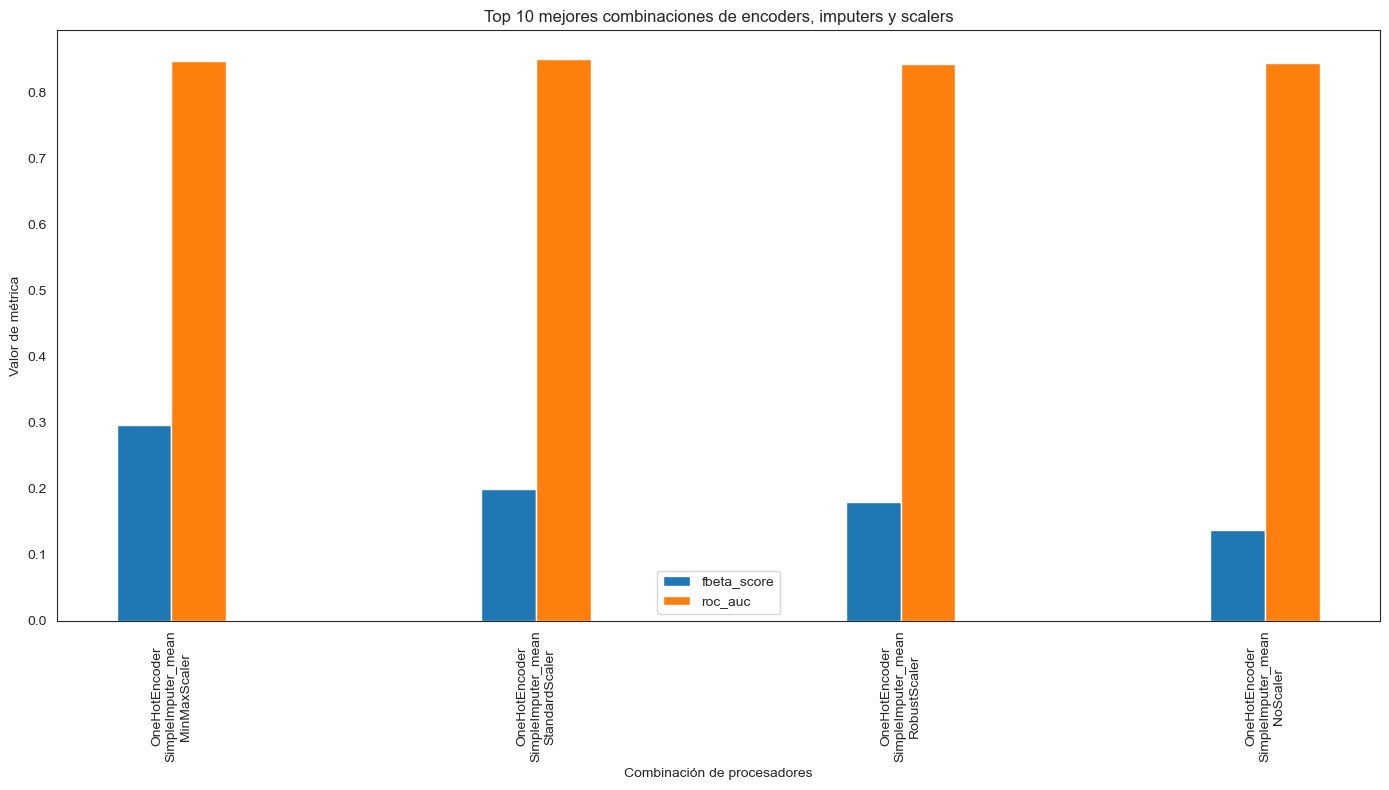

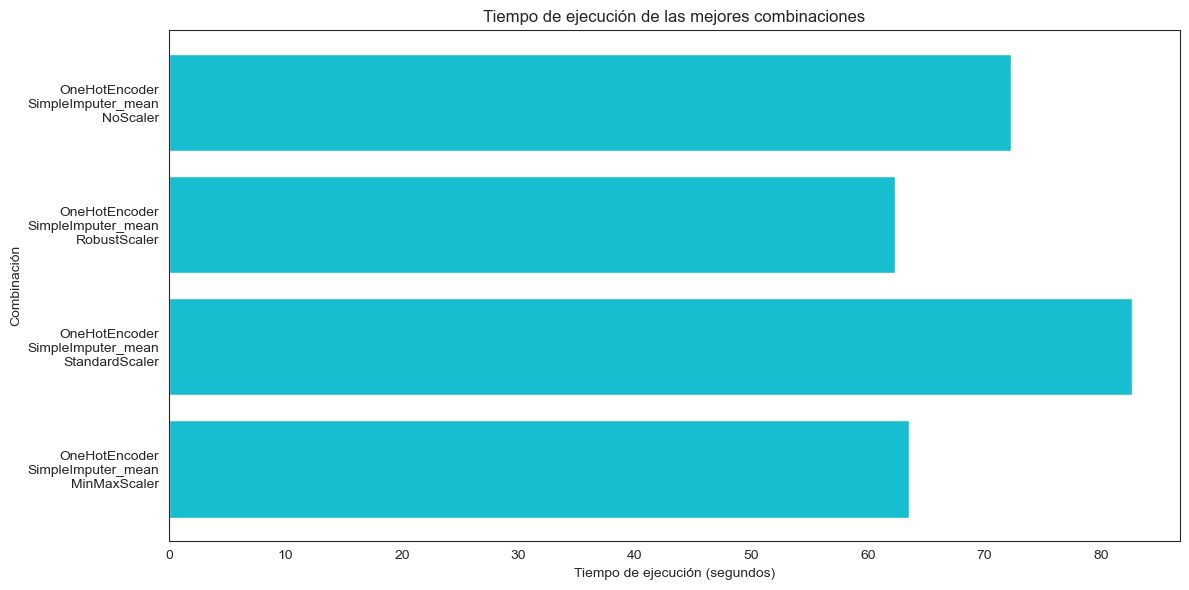


--- MEJOR COMBINACI√ìN ---
Encoder: OneHotEncoder
Imputer: SimpleImputer_mean
Scaler: MinMaxScaler
F-beta score: 0.2965
ROC AUC: 0.8483


In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Separar columnas num√©ricas y categ√≥ricas
X = df.drop(columns=['exito'])
y = df['exito']
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Lista de opciones a probar
encoders = [
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore')),
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('TargetEncoder', TargetEncoder())
]

# Lista de imputers
imputers = [
    ('SimpleImputer_mean', SimpleImputer(strategy='mean')),
    ('SimpleImputer_median', SimpleImputer(strategy='median')),
    ('SimpleImputer_most_frequent', SimpleImputer(strategy='most_frequent'))
]

scalers = [
    ('NoScaler', None),
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler())
]

# Funci√≥n para evaluar el modelo
def evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline):
    start_time = time()
    # Ajustar el modelo
    pipeline.fit(X_train, y_train)
    
    # Predecir en el conjunto de validaci√≥n
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    
    # Calcular solo las m√©tricas necesarias: F-beta score y AUC
    fbeta = f1_score(y_val, y_pred)  # Aqu√≠ f1_score es equivalente a fbeta con beta=1
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    # Tiempo de ejecuci√≥n
    end_time = time()
    execution_time = end_time - start_time
    
    resultados = {
        'fbeta_score': fbeta,
        'roc_auc': roc_auc,
        'execution_time': execution_time
    }
    
    return resultados

# Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Crear un DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=[
    'encoder', 'imputer', 'scaler', 
    'fbeta_score', 'roc_auc', 
    'execution_time'
])

# Importar Pipeline para los transformadores num√©ricos
from sklearn.pipeline import Pipeline

# Probar todas las combinaciones
for encoder_name, encoder in encoders:
    for scaler_name, scaler in scalers:
        print(f"\nEvaluando combinaci√≥n: {encoder_name}, SimpleImputer_mean, {scaler_name}")
        
        # Crear el preprocesador
        numeric_transformer = imputer
        if scaler is not None:
            numeric_transformer = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler)
            ])
        
        # Para Target Encoder necesitamos un manejo especial
        if encoder_name == 'TargetEncoder':
            # Para Target Encoder, necesitamos aplicarlo directamente a X_train y X_val con y_train
            # Primero preprocesamos los datos num√©ricos
            num_preprocessor = ColumnTransformer([
                ('num', numeric_transformer, num_cols)
            ], remainder='passthrough')
            
            # Procesamos los datos num√©ricos
            X_train_processed = pd.DataFrame(num_preprocessor.fit_transform(X_train))
            X_val_processed = pd.DataFrame(num_preprocessor.transform(X_val))
            
            # Ahora aplicamos Target Encoder a las columnas categ√≥ricas
            for col in cat_cols:
                # Ajustamos el codificador en el conjunto de entrenamiento
                encoder.fit(X_train[col], y_train)
                # Transformamos ambos conjuntos
                X_train_processed[col] = encoder.transform(X_train[col])
                X_val_processed[col] = encoder.transform(X_val[col])
            
            # Creamos un pipeline simplificado sin preprocesamiento (ya lo hicimos manualmente)
            pipeline = ImbPipeline(steps=[
                ('sampler', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
            ])
            
            # Evaluamos el modelo con los datos ya procesados
            try:
                resultado = evaluar_pipeline(X_train_processed, y_train, X_val_processed, y_val, pipeline)
            except Exception as e:
                print(f"Error con Target Encoder: {e}")
                continue
        else:
            # Para los dem√°s encoders, usamos el enfoque normal con ColumnTransformer
            preprocessor = ColumnTransformer([
                ('num', numeric_transformer, num_cols),
                ('cat', encoder, cat_cols)
            ])
            
            # Crear pipeline con SMOTE + RandomForest
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('sampler', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
            ])
            
            # Evaluar el modelo
            try:
                resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
            except Exception as e:
                print(f"Error con combinaci√≥n {encoder_name}, SimpleImputer_mean, {scaler_name}: {e}")
                continue
        
        # Agregar resultado al DataFrame
        new_row = {
            'encoder': encoder_name,
            'imputer': 'SimpleImputer_mean',
            'scaler': scaler_name,
            'fbeta_score': resultado['fbeta_score'],  # ‚Üê FIXED: use 'fbeta_score'
            'roc_auc': resultado['roc_auc'],
            'execution_time': resultado['execution_time']
        }
        
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
        print(f"Fb-score: {resultado['fbeta_score']:.4f}")
        print(f"ROC AUC: {resultado['roc_auc']:.4f}")
        print(f"Tiempo de ejecuci√≥n: {resultado['execution_time']:.2f} segundos")
                


# Ordenar los resultados por fbeta_score (descendente)
results_df = results_df.sort_values('fbeta_score', ascending=False).reset_index(drop=True)

# Mostrar los mejores resultados
print("\n--- TOP 5 MEJORES COMBINACIONES ---")
print(results_df.head(5))

# Visualizaci√≥n de los mejores resultados
plt.figure(figsize=(14, 8))
top_results = results_df.head(10)

# Crear etiquetas para el eje x
x_labels = [f"{row['encoder']}\n{row['imputer']}\n{row['scaler']}" for _, row in top_results.iterrows()]

# Gr√°fico de barras para las m√©tricas
metrics = ['fbeta_score', 'roc_auc']
colors = ['#1f77b4', '#ff7f0e']

for i, metric in enumerate(metrics):
    plt.bar(np.arange(len(top_results)) + i*0.15, top_results[metric], width=0.15, 
            label=metric, color=colors[i])

plt.xlabel('Combinaci√≥n de procesadores')
plt.ylabel('Valor de m√©trica')
plt.title('Top 10 mejores combinaciones de encoders, imputers y scalers')
plt.xticks(np.arange(len(top_results)) + 0.075, x_labels, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Visualizaci√≥n de tiempos de ejecuci√≥n
plt.figure(figsize=(12, 6))
plt.barh(x_labels, top_results['execution_time'], color='#17becf')
plt.xlabel('Tiempo de ejecuci√≥n (segundos)')
plt.ylabel('Combinaci√≥n')
plt.title('Tiempo de ejecuci√≥n de las mejores combinaciones')
plt.tight_layout()
plt.show()

# Obtener la mejor combinaci√≥n
best_combination = results_df.iloc[0]
print("\n--- MEJOR COMBINACI√ìN ---")
print(f"Encoder: {best_combination['encoder']}")
print(f"Imputer: {best_combination['imputer']}")
print(f"Scaler: {best_combination['scaler']}")
print(f"F-beta score: {best_combination['fbeta_score']:.4f}")
print(f"ROC AUC: {best_combination['roc_auc']:.4f}")

### Discretizaci√≥n de la variable `homepage_url`

La variable `homepage_url` indica si una startup tiene o no una p√°gina web registrada. Aunque su contenido es textual, su presencia puede reflejar cierto grado de profesionalizaci√≥n o visibilidad que favorece el √©xito de la start-up.

**Transformaci√≥n aplicada**:  
Se ha convertido en una variable binaria (`has_url`), con valor `1` si la URL est√° presente y `0` en caso contrario.

Esta transformaci√≥n permite incluir esta informaci√≥n como una caracter√≠stica √∫til en los modelos de clasificaci√≥n.


In [69]:
df.head(10)

homepage_url  \
0          http://www.waywire.com   
2    http://www.rockyourpaper.org   
3   http://www.InTouchNetwork.com   
4                             NaN   
7              http://www.0-6.com   
10        http://www.123listo.com   
15       http://10minuteswith.com   
16      http://www.10-20media.com   
17           http://1000corks.com   
18     http://www.1000markets.com   

                                        category_list  funding_total_usd  \
0          |Entertainment|Politics|Social Media|News|          1750001.0   
2                              |Publishing|Education|            40001.0   
3   |Electronics|Guides|Coffee|Restaurants|Music|i...          1500001.0   
4                       |Tourism|Entertainment|Games|            60002.0   
7                                       |Curated Web|          4000001.0   
10                                       |E-Commerce|            40001.0   
15                                        |Education|          8400002.0   
16                                       |E-Commerce|                4.0   
17                                           |Search|            40001.0   
18                      |Marketplaces|Art|E-Commerce|           500001.0   

    exito country_code state_code            region         city  \
0       1          USA         NY     New York City     New York   
2       0          EST        NaN           Tallinn      Tallinn   
3       0          GBR        NaN            London       London   
4       0          USA         TX            Dallas   Fort Worth   
7       0          NaN        NaN               NaN          NaN   
10      0          CHL        NaN          Santiago   Las Condes   
15      0          GBR        NaN            London       London   
16      0          USA         MD         Baltimore     Woodbine   
17      0          USA         OR  Portland, Oregon  Lake Oswego   
18      1          NaN        NaN               NaN          NaN   

    funding_rounds founded_at founded_month founded_quarter  founded_year  \
0              1.0 2012-06-01    2012-06-01         2012-Q2             4   
2              1.0 2012-10-26    2012-10-01         2012-Q4             4   
3              1.0 2011-04-01    2011-04-01         2011-Q2             4   
4              2.0 2014-01-01    2014-01-01         2014-Q1             4   
7              1.0 2007-01-01    2007-01-01         2007-Q1             4   
10             1.0 2012-01-01    2012-01-01         2012-Q1             4   
15             2.0 2013-01-01    2013-01-01         2013-Q1             4   
16             4.0 2001-01-01    2001-01-01         2001-Q1             4   
17             1.0 2008-01-01    2008-01-01         2008-Q1             4   
18             1.0 2009-01-01    2009-01-01         2009-Q1             4   

   first_funding_at last_funding_at       seed    venture  \
0        2012-06-30      2012-06-30  1750000.0        0.0   
2        2012-08-09      2012-08-09    40000.0        0.0   
3        2011-04-01      2011-04-01  1500000.0        0.0   
4        2014-08-17      2014-09-26        0.0        0.0   
7        2008-03-19      2008-03-19        0.0  2000000.0   
10       2013-02-18      2013-02-18    40000.0        0.0   
15       2013-01-01      2014-10-09   400000.0  4000000.0   
16       2009-06-18      2011-12-28        0.0        0.0   
17       2011-08-23      2011-08-23    40000.0        0.0   
18       2009-05-15      2009-05-15   500000.0        0.0   

    equity_crowdfunding  undisclosed  convertible_note  angel  grant  \
0                   0.0          0.0               0.0    0.0    0.0   
2                   0.0          0.0               0.0    0.0    0.0   
3                   0.0          0.0               0.0    0.0    0.0   
4               60000.0          0.0               0.0    0.0    0.0   
7                   0.0          0.0               0.0    0.0    0.0   
10                  0.0          0.0               0.0    0.0    0.0   
15 

In [70]:
# Crear variable binaria: 1 si tiene homepage_url, 0 si est√° vac√≠a o es NaN
df['homepage_url'] = df['homepage_url'].notna().astype(int)

#### 6.2 Validaci√≥n

In [71]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

X = df.drop(columns=['exito'])
y = df['exito']

num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

if 'homepage_url' not in num_cols:
    num_cols.append('homepage_url')

# Mapear nombres a objetos reales
encoder_map = {
    'OneHotEncoder': OneHotEncoder(handle_unknown='ignore'),
    'OrdinalEncoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'TargetEncoder': TargetEncoder()
}
scaler_map = {
    'NoScaler': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}
imputer_map = {
    'SimpleImputer_mean': SimpleImputer(strategy='mean'),
    'SimpleImputer_median': SimpleImputer(strategy='median'),
    'SimpleImputer_most_frequent': SimpleImputer(strategy='most_frequent')
}

# Obtener objetos desde resultados
best_encoder_name = best_combination['encoder']
best_imputer_name = best_combination['imputer']
best_scaler_name = best_combination['scaler']

best_encoder = encoder_map[best_encoder_name]
best_imputer = imputer_map[best_imputer_name]
best_scaler = scaler_map[best_scaler_name]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Dividir
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Pipeline num√©rico
if best_scaler is not None:
    numeric_transformer = Pipeline([
        ('imputer', best_imputer),
        ('scaler', best_scaler)
    ])
else:
    numeric_transformer = best_imputer

# Pipeline categ√≥rico
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', best_encoder)
])

# Preprocesamiento completo
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Pipeline completo
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Evaluar
resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)

# Mostrar resultados
print("\n--- Evaluaci√≥n con la mejor combinaci√≥n + homepage_url ---")
print(f"Encoder: {best_encoder_name}")
print(f"Imputer: {best_imputer_name}")
print(f"Scaler: {best_scaler_name}")
print(f"F-beta score: {resultado['fbeta_score']:.4f}")
print(f"ROC AUC: {resultado['roc_auc']:.4f}")
print(f"Tiempo: {resultado['execution_time']:.2f} s")




--- Evaluaci√≥n con la mejor combinaci√≥n + homepage_url ---
Encoder: OneHotEncoder
Imputer: SimpleImputer_mean
Scaler: MinMaxScaler
F-beta score: 0.3271
ROC AUC: 0.8511
Tiempo: 55.74 s


Se puede observar que ha mejorado tanto el F-beta score como el valor de ROC AUC.

## 8. Estandarizaci√≥n de los datos

Seg√∫n la variable, aplicaremos un tipo de estandarizaci√≥n u otro.

Para que todas las variables num√©ricas est√©n en rangos comparables:

- **Z-score (StandardScaler)** en aquellas columnas con distribuci√≥n relativamente ‚Äúnormal‚Äù  
  Calcula \((x - \mu)/\sigma\), de modo que la media quede en 0 y la desviaci√≥n t√≠pica en 1.  

- **Min-Max (MinMaxScaler)** en las columnas con valores muy dispersos  
  Reescala los datos al rango \([0,1]\) seg√∫n \((x - \min) / (\max - \min)\).  

Con esto, evitamos que las magnitudes de unas variables dominen a las otras cuando entren en el modelo.



Evaluando con scaler: standard


C:\Users\marti\AppData\Local\Temp\ipykernel_20472\1719797310.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scaler_results = pd.concat([scaler_results, pd.DataFrame([{


Fb-score: 0.2055
ROC AUC: 0.8485
Tiempo: 39.81 s

Evaluando con scaler: minmax
Fb-score: 0.3271
ROC AUC: 0.8511
Tiempo: 45.82 s

Evaluando con scaler: robust
Fb-score: 0.1742
ROC AUC: 0.8413
Tiempo: 48.71 s

Evaluando con scaler: none
Fb-score: 0.1878
ROC AUC: 0.8446
Tiempo: 54.96 s

--- Resultados por tipo de escalado ---
     scaler  fbeta_score   roc_auc  execution_time
0    minmax     0.327130  0.851094       45.819612
1  standard     0.205496  0.848465       39.808422
2      none     0.187817  0.844634       54.962725
3    robust     0.174242  0.841277       48.714287


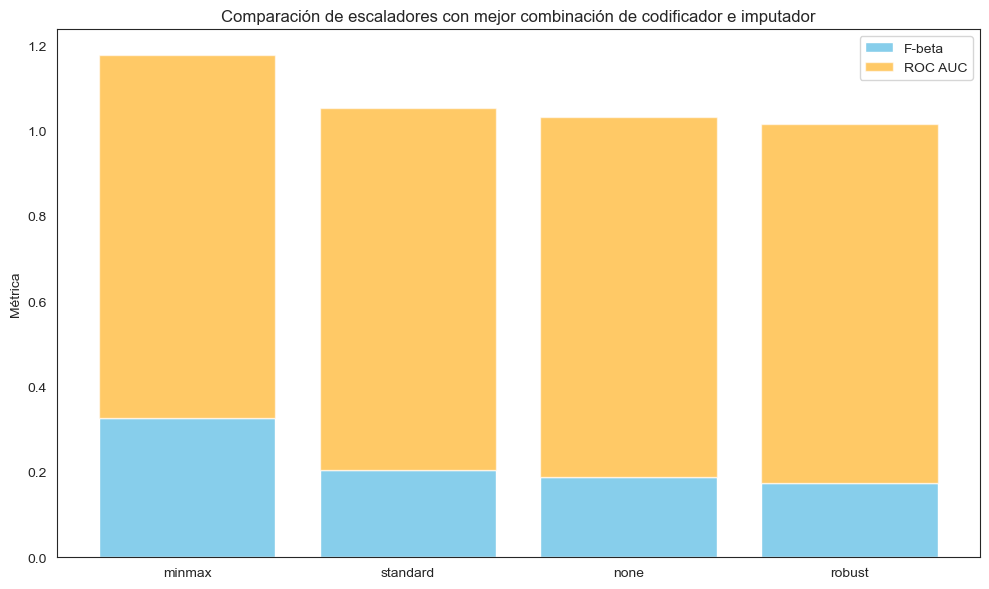

In [73]:
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

scaling_methods = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'none': FunctionTransformer()  # identidad
}

# DataFrame para guardar resultados
scaler_results = pd.DataFrame(columns=[
    'scaler', 'fbeta_score', 'roc_auc', 'execution_time'
])

# Dividir datos (por si no estaba hecho a√∫n)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

for scaler_name, scaler in scaling_methods.items():
    print(f"\nEvaluando con scaler: {scaler_name}")
    
    # Pipeline num√©rico
    if scaler_name != 'none':
        numeric_transformer = Pipeline([
            ('imputer', best_imputer),
            ('scaler', scaler)
        ])
    else:
        numeric_transformer = best_imputer  # solo imputaci√≥n

    # Pipeline categ√≥rico (fijo)
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', best_encoder)
    ])
    
    # Preprocesamiento
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])
    
    # Pipeline completo
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampler', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])
    
    # Evaluar
    resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
    
    # Guardar resultado
    scaler_results = pd.concat([scaler_results, pd.DataFrame([{
        'scaler': scaler_name,
        'fbeta_score': resultado['fbeta_score'],
        'roc_auc': resultado['roc_auc'],
        'execution_time': resultado['execution_time']
    }])], ignore_index=True)

    print(f"Fb-score: {resultado['fbeta_score']:.4f}")
    print(f"ROC AUC: {resultado['roc_auc']:.4f}")
    print(f"Tiempo: {resultado['execution_time']:.2f} s")

# Ordenar resultados por fbeta_score
scaler_results = scaler_results.sort_values('fbeta_score', ascending=False).reset_index(drop=True)

print("\n--- Resultados por tipo de escalado ---")
print(scaler_results)

# Visualizaci√≥n opcional
plt.figure(figsize=(10, 6))
plt.bar(scaler_results['scaler'], scaler_results['fbeta_score'], color='skyblue', label='F-beta')
plt.bar(scaler_results['scaler'], scaler_results['roc_auc'], color='orange', alpha=0.6, label='ROC AUC', bottom=scaler_results['fbeta_score'])
plt.ylabel("M√©trica")
plt.title("Comparaci√≥n de escaladores con mejor combinaci√≥n de codificador e imputador")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Selecci√≥n de variables

Ahora que hemos creado nuevas variables, vamos a utilizar t√©cnicas de selecci√≥n para identificar las m√°s relevantes para nuestro modelo. Utilizaremos m√©todos basados en filtros, wrappers y an√°lisis de correlaciones.

### 9.1 M√©todos basados en filtros

Aplicamos t√©cnicas de selecci√≥n de variables basadas en filtros para identificar las variables m√°s relevantes para la predicci√≥n de adquisiciones. Utilizaremos los m√©todos SelectKBest con la puntuaci√≥n f_classif para evaluar la importancia de cada variable.

In [75]:
# from types import SimpleNamespace
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.feature_selection import SelectKBest
# from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

# # 0) Construye el objeto `best` a partir de tu DataFrame de resultados:
# best_row = encoding_results.iloc[0]
# best = SimpleNamespace(**best_row.to_dict())
# # ahora `best.encoding` es, por ejemplo, 'ordinal' o 'target'

# def build_pipeline(score_func, k):
#     # --- Num√©ricas ---
#     numeric_pipeline = Pipeline([
#         ('imputer', numeric_imputers[best_numeric_imp]),
#         ('scaler',  scaling_methods[best_scaling_method])
#     ])
#     # --- Categ√≥ricas: usa directamente el pipeline de imputaci√≥n+encoding ---
#     cat_pipeline = categorical_imputers[best_categorical_imp]

#     preprocessor = ColumnTransformer([
#         ('num', numeric_pipeline, numerical_cols),
#         ('cat', cat_pipeline,     categorical_cols),
#     ], remainder='drop')

#     return Pipeline([
#         ('pre',               preprocessor),
#         ('feature_selection', SelectKBest(score_func=score_func, k=k)),
#         ('clf',               knn_neighbors())
#     ])

# # Y luego tu bucle de evaluaci√≥n sin cambiar nada m√°s:
# for score_name, score_func in [('f_classif', f_classif),
#                                ('mutual_info', mutual_info_classif)]:
#     for k in [5, 10, 15]:
#         print(f"\n--- SelectKBest con {score_name}, k={k} ---")
#         pipe = build_pipeline(score_func, k)
#         pipe.fit(X_train, y_train)
#         scores = evaluar_pipeline(
#             X_val, y_val, pipe,
#             beta=0.7, test_size=0.2, random_state=42
#         )
#         print(f" ‚Üí F‚ÇÄ.‚Çá = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")


### 9.2 M√©todos basados en wrappers

Ahora aplicaremos m√©todos basados en wrappers para seleccionar variables, espec√≠ficamente la t√©cnica Recursive Feature Elimination (RFE) que elimina iterativamente las variables menos importantes.

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import (
#     FunctionTransformer, OneHotEncoder, OrdinalEncoder
# )
# from sklearn.feature_selection import RFE, SelectKBest, f_classif
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

# # tus encoders (todos sin sparse_output donde importe)
# categorical_encoders = {
#     'onehot':  OneHotEncoder(handle_unknown='ignore',
#                               sparse_output=False),
#     'ordinal': OrdinalEncoder(handle_unknown='use_encoded_value',
#                               unknown_value=-1),
#     'target':  TargetEncoder()  # asume devuelve dense
# }

# # helper que convierte *cualquier* CSR a numpy.ndarray
# to_dense = FunctionTransformer(
#     lambda X: X.toarray() if hasattr(X, "toarray") else X,
#     validate=False
# )

# def build_rfe_pipeline(n_features, step=0.2):
#     numeric_pipeline = Pipeline([
#         ('imp', numeric_imputers[best_numeric_imp]),
#         ('to_dense', to_dense),
#         ('scaler', scaling_methods[best_scaling_method])
#     ])
#     cat_pipeline = Pipeline([
#         # <-- Aqu√≠:
#         ('imp', categorical_imputers[best_categorical_imp]),  
#         ('to_dense', to_dense),
#         ('enc', categorical_encoders[best.encoding])
#     ])

#     preprocessor = ColumnTransformer([
#         ('num', numeric_pipeline,   numerical_cols),
#         ('cat', cat_pipeline,       categorical_cols),
#     ], remainder='drop')

#     rfe = RFE(
#         estimator=LogisticRegression(solver='liblinear',
#                                      max_iter=2000,
#                                      random_state=42),
#         n_features_to_select=n_features,
#         step=step
#     )

#     return Pipeline([
#         ('pre',      preprocessor),
#         ('rfe',      rfe),
#         ('knn',      KNeighborsClassifier())
#     ])


# def build_kbest_pipeline(score_func, k):
#     numeric_pipeline = Pipeline([
#         ('imputer', numeric_imputers[best_numeric_imp]),
#         ('to_dense', to_dense),
#         ('scaler',   scaling_methods[best.scaling_method]),
#     ])
#     cat_pipeline = Pipeline([
#         ('imputer', numeric_imputers[best.categorical_imp]),
#         ('to_dense', to_dense),
#         ('encoder', categorical_encoders[best.encoding]),
#     ])

#     preprocessor = ColumnTransformer([
#         ('num', numeric_pipeline,   numerical_cols),
#         ('cat', cat_pipeline,       categorical_cols),
#     ], remainder='drop')

#     return Pipeline([
#         ('pre',   preprocessor),
#         ('kbest', SelectKBest(score_func=score_func, k=k)),
#         ('knn',   KNeighborsClassifier())
#     ])


# # --- ejemplo de uso RFE (wrapper) ---
# pipe_rfe = build_rfe_pipeline(n_features=10, step=0.2)
# pipe_rfe.fit(X_train, y_train)

# y_proba = pipe_rfe.predict_proba(X_val)[:,1]
# y_pred  = pipe_rfe.predict(X_val)

# from sklearn.metrics import fbeta_score, precision_recall_curve, auc
# f0_7    = fbeta_score(y_val, y_pred, beta=0.7)
# prec, rec, _ = precision_recall_curve(y_val, y_proba)
# auc_pr  = auc(rec, prec)

# print(f"RFE ‚Üí F‚ÇÄ.‚Çá = {f0_7:.4f}, AUC-PR = {auc_pr:.4f}")


## 10. Detecci√≥n de ruido

In [ ]:
%pip install imbalanced-learn

In [ ]:
# 1) Imports
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, AllKNN

# 3) Preprocesador √≥ptimo
numeric_pipeline = SKPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler',  StandardScaler())
])
if categorical_cols:
    cat_pipeline = SKPipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipeline,     categorical_cols)
    ], remainder='drop')
else:
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols)
    ], remainder='drop')

# 4) Samplers de eliminaci√≥n de ruido
noise_methods = {
    'TomekLinks': TomekLinks(sampling_strategy='all'),
    'ENN':        EditedNearestNeighbours(sampling_strategy='all', kind_sel='mode', n_neighbors=3),
    'AllKNN':     AllKNN(sampling_strategy='all', kind_sel='mode', n_neighbors=3)
}

# 5) Pipeline: primero preprocesa (‚Üí datos num√©ricos), luego sampler
for name, sampler in noise_methods.items():
    pipe = ImbPipeline([
        ('pre',   preprocessor),  # transforma X a num√©rico
        ('noise', sampler)        # ahora puede aplicar fit_resample
    ])
    X_clean, y_clean = pipe.fit_resample(X_train, y_train)
    removed = len(y_train) - len(y_clean)
    print(f"{name}: eliminadas {removed} muestras de ruido (quedan {len(y_clean)})")


## 11. Efecto de uso de √°rboles de decisi√≥n

In [79]:
%pip install xgboost
%pip install catboost
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/102.5 MB 5.0 MB/s eta 0:00:21
   ---------------------------------------- 0.5/102.5 MB 5.2 MB/s eta 0:00:20
   ---------------------------------------- 0.8/102.5 MB 5.8 MB/s eta 0:00:18
   ---------------------------------------- 1.2/102.5 MB 6.3 MB/s eta 0:00:17
    --------------------------------------- 1.5/102.5 MB 6.5 MB/s eta 0:00:16
    --------------------------------------- 1.9/102.5 MB 6.8 MB/s eta 0:00:15
    --------------------------------------- 2.3/102.5 MB 7.1 MB/s eta 0:00:15
   - -------------------------------------- 2.8/102.5 MB 7.5 MB/s eta 0:00:14
   - -------------------------------------- 3.2/102.5 MB 8.0 MB/s eta 0:00:13
   - -------------------------------------- 3.8/102.5 MB 8.1 MB/s eta 0:00:13
   - -------------------------------------- 4.3/102.5 MB 8.2 MB/s eta 0:00:12
   - 


Evaluando Random Forest...


C:\Users\marti\AppData\Local\Temp\ipykernel_20472\2529209405.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([


Fb-score: 0.5070 | ROC AUC: 0.8997 | Tiempo: 0.82s

Evaluando XGBoost...
Fb-score: 0.6000 | ROC AUC: 0.9170 | Tiempo: 0.26s

Evaluando CatBoost...
Fb-score: 0.6441 | ROC AUC: 0.9425 | Tiempo: 1.91s

--- Resultados finales ---
           model  fbeta_score   roc_auc  execution_time
0       CatBoost     0.644068  0.942514        1.914153
1        XGBoost     0.600000  0.916978        0.257193
2  Random Forest     0.507042  0.899720        0.816321


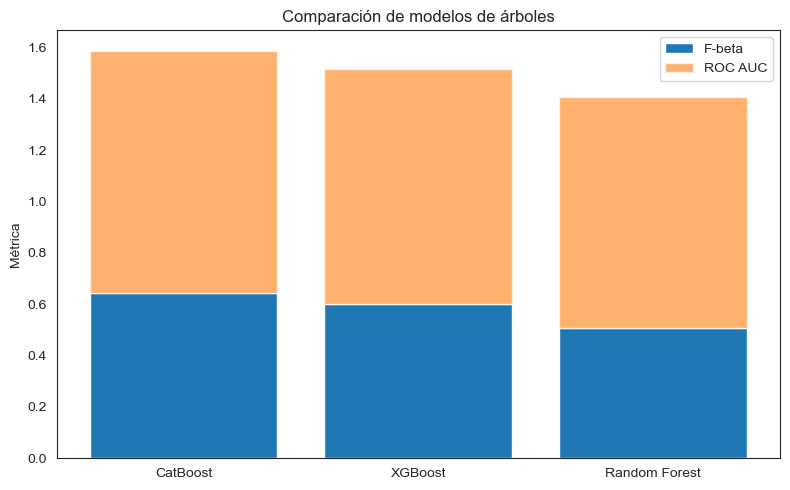

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # si ya lo tienes instalado

# 1) Divisi√≥n de datos
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 2) Definici√≥n de los modelos con los mejores hiperpar√°metros
models = {
    'Random Forest': RandomForestClassifier(
        class_weight='balanced', random_state=42,
        criterion='gini', max_depth=7, max_features='log2',
        min_samples_leaf=3, n_estimators=87
    ),
    'XGBoost': XGBClassifier(
        objective='binary:logistic', verbosity=1, random_state=42,
        colsample_bytree=0.9186171947440931,
        learning_rate=0.05252739326386423,
        max_depth=8, min_child_weight=5,
        subsample=0.6624074561769746,
        n_estimators=120
    ),
    'CatBoost': CatBoostClassifier(
        od_type='Iter', bootstrap_type='Bernoulli', od_wait=50,
        random_state=42, depth=4, iterations=664,
        l2_leaf_reg=2.3089382562214897,
        learning_rate=0.07089738514754339,
        subsample=0.8733054075301833,
        colsample_bylevel=0.6312499015239497,
        verbose=False
    )
}

# 3) DataFrame para almacenar resultados
results = pd.DataFrame(columns=['model', 'fbeta_score', 'roc_auc', 'execution_time'])

# 4) Bucle de evaluaci√≥n
for name, clf in models.items():
    print(f"\nEvaluando {name}...")
    preprocessor = ColumnTransformer([
        ('num', best_imputer, num_cols),
        ('cat', best_encoder, cat_cols)
    ])
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', SMOTE(random_state=42)),  # si no usas SMOTE, elimina esta l√≠nea
        ('clf', clf)
    ])
    
    start = time()
    score = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
    elapsed = time() - start
    
    results = pd.concat([
        results,
        pd.DataFrame([{
            'model': name,
            'fbeta_score': score['fbeta_score'],
            'roc_auc': score['roc_auc'],
            'execution_time': elapsed
        }])
    ], ignore_index=True)
    print(f"Fb-score: {score['fbeta_score']:.4f} | ROC AUC: {score['roc_auc']:.4f} | Tiempo: {elapsed:.2f}s")

# 5) Ordenar y mostrar resultados
results = results.sort_values('fbeta_score', ascending=False).reset_index(drop=True)
print("\n--- Resultados finales ---")
print(results)

# 6) Visualizaci√≥n
plt.figure(figsize=(8, 5))
plt.bar(results['model'], results['fbeta_score'], label='F-beta')
plt.bar(results['model'], results['roc_auc'],
        bottom=results['fbeta_score'], alpha=0.6, label='ROC AUC')
plt.ylabel('M√©trica')
plt.title('Comparaci√≥n de modelos de √°rboles')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Comparison of Instance Selection and Sampling Methods on Startup Investments Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, precision_recall_curve, auc

# Imbalanced-learn methods
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

def run_comparison(df, sample_fraction=0.3, random_state=42):
    """
    Run comparison of instance selection and sampling methods on a given dataframe.
    Parameters:
        df: pandas DataFrame - preprocessed dataframe with features and target 'exito'
        sample_fraction: float - fraction of data to use to reduce runtime
        random_state: int - random seed for reproducibility
    """
    # Use a sample of the dataframe to reduce runtime
    df_sample = df.sample(frac=sample_fraction, random_state=random_state).reset_index(drop=True)

    # Separate features and target
    X = df_sample.drop(columns=['exito'])
    y = df_sample['exito']

    # Separate numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    # Define preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Define evaluation function
    def evaluar_pipeline(X, y, pipeline, beta=0.7, test_size=0.2, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        elif hasattr(pipeline, "decision_function"):
            y_proba = pipeline.decision_function(X_test)
        else:
            y_proba = None
        scores = {
            "f_beta": fbeta_score(y_test, y_pred, beta=beta),
        }
        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            auc_pr = auc(recall, precision)
            scores["AUC-PR"] = auc_pr
        else:
            scores["AUC-PR"] = 0
        return scores

    # Define sampling and instance selection methods to compare
    methods = {
        "RandomUnderSampler": RandomUnderSampler(sampling_strategy='auto', random_state=random_state),
        "TomekLinks": TomekLinks(sampling_strategy='auto'),
        "OneSidedSelection": OneSidedSelection(sampling_strategy='auto', random_state=random_state),
        "NeighbourhoodCleaningRule": NeighbourhoodCleaningRule(sampling_strategy='auto'),
        "RandomOverSampler": RandomOverSampler(sampling_strategy='auto', random_state=random_state),
        # "CondensedNearestNeighbour": CondensedNearestNeighbour(sampling_strategy='auto', random_state=random_state),
        # tarda muchisimo en ejecutarase por eso no lo probare
        "SMOTE": SMOTE(sampling_strategy='auto', random_state=random_state),
        "SMOTETomek": SMOTETomek(sampling_strategy='auto', random_state=random_state),
        "SMOTEENN": SMOTEENN(sampling_strategy='auto', random_state=random_state)
    }

    results = []

    for name, sampler in methods.items():
        print(f"Evaluating method: {name}")
        # Build pipeline with sampler and classifier
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', KNeighborsClassifier())
        ])
        try:
            scores = evaluar_pipeline(X, y, pipeline, beta=0.7)
            print(f"f_beta: {scores['f_beta']:.4f}, AUC-PR: {scores['AUC-PR']:.4f}")
            results.append({
                'method': name,
                'f_beta': scores['f_beta'],
                'AUC-PR': scores['AUC-PR']
            })
        except Exception as e:
            print(f"Error evaluating {name}: {e}")
            results.append({
                'method': name,
                'f_beta': None,
                'AUC-PR': None,
                'error': str(e)
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).sort_values(by=['f_beta', 'AUC-PR'], ascending=False)
    print("\nSummary of results:")
    print(results_df)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='method', y='f_beta', data=results_df)
    plt.title('Comparison of f_beta scores by method')
    plt.xticks(rotation=45)
    plt.ylabel('f_beta score')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='method', y='AUC-PR', data=results_df)
    plt.title('Comparison of AUC-PR scores by method')
    plt.xticks(rotation=45)
    plt.ylabel('AUC-PR score')
    plt.tight_layout()
    plt.show()

## 12. Muestreo de datos para problemas no balanceados

## 13. Cambio de umbrales de clasificaci√≥n